## Better Millennium - Retail Investor Solution

**Author:** Xibei(Julian) He
<br>
**Date:** July 7, 2022

![](https://www.ameriprise.com/binaries/content/gallery/ampcom/products/amp_facet_orange_prod.png)

## Overview

The goal to be achieved in this project is to build a comprehensive quantitative model to provide assistance to retail investor. 
This investment assistance tool provides prediciton on price action of stock, and also generate model portfolios depends on investor's risk and reward profile. 

## Business Problem

According to Fortune, Today’s millennials have more economic power than any generation that preceded them. They are earning more, saving more, and investing earlier. 31% of millennials started investing before 21, compared to 9% of baby boomers and 14% of Gen X. For example, 67% of millennials own stock. They are likely to lead a new way of investing that transform the financial sector. However, investing or trading stock is never easy. According to multiple research studies, 80% of day traders quit within the first 2 years. And only 1% of day traders remain profitable. Trading stock is much harder than people think. 

## Data Understanding

- Datasets: I am using daily returns of any stock from S&P500 for the past 10 years. 

- Limitation: I wish I could access to historical rating and ratings by different institutions to develop more functions. I will save that for future development. 

#### Importing packages

In [1]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split
import pandas_datareader as web
from scipy import stats
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
import statsmodels.api as sm
yf.pdr_override()
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
import math
import time
from datetime import date
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
# Basic stuff
from calendar import monthrange
from dateutil.relativedelta import relativedelta

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 10)

from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
# from tensorflow import set_random_seed
import tensorflow as tf
tf.random.set_seed(101) 
# Set seeds to ensure same output results

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

# Input params 
stk_path = "data/AAPL.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14

## EDA & Data Preparation

In [3]:
# Import data from yahoo finance and get used to basic EDA of time series
aapl = web.get_data_yahoo("AAPL",
start = "2012-01-01",
end = "2022-06-01")

In [4]:
aapl

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.557465
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.624948
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.765112
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.898555
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.878098
...,...,...,...,...,...,...
2022-05-25,141.789993,138.339996,138.429993,140.520004,92482700.0,140.520004
2022-05-26,144.339996,137.139999,137.389999,143.779999,90601500.0,143.779999
2022-05-27,149.679993,145.259995,145.389999,149.639999,90978500.0,149.639999


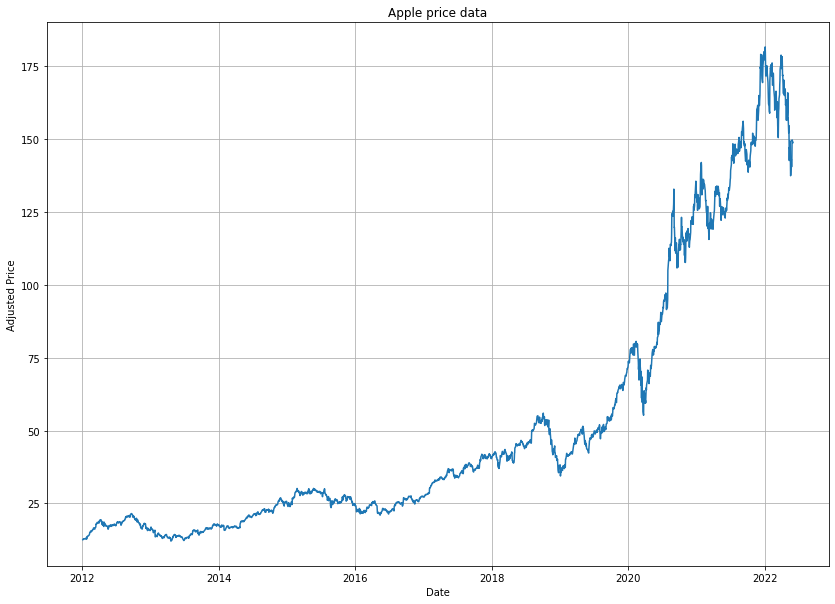

In [5]:
# Plot the Apple stock price chart
fig, ax = plt.subplots()
ax.plot(aapl["Adj Close"]) 
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Price")
ax.set_title("Apple price data")
plt.grid()
plt.show()

In [6]:
aapl_daily_returns = aapl['Adj Close'].pct_change()
aapl_monthly_returns = aapl['Adj Close'].resample('M').ffill().pct_change()

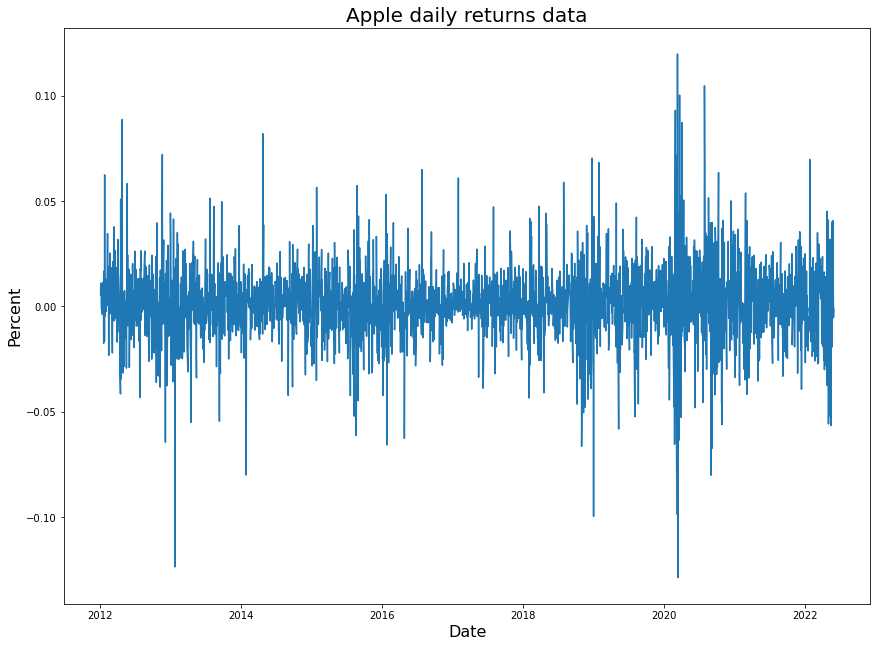

In [7]:
# plot the daily return
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(aapl_daily_returns)
ax1.set_xlabel("Date", fontsize=16)
ax1.set_ylabel("Percent", fontsize=16)
ax1.set_title("Apple daily returns data", fontsize=20)
plt.show()

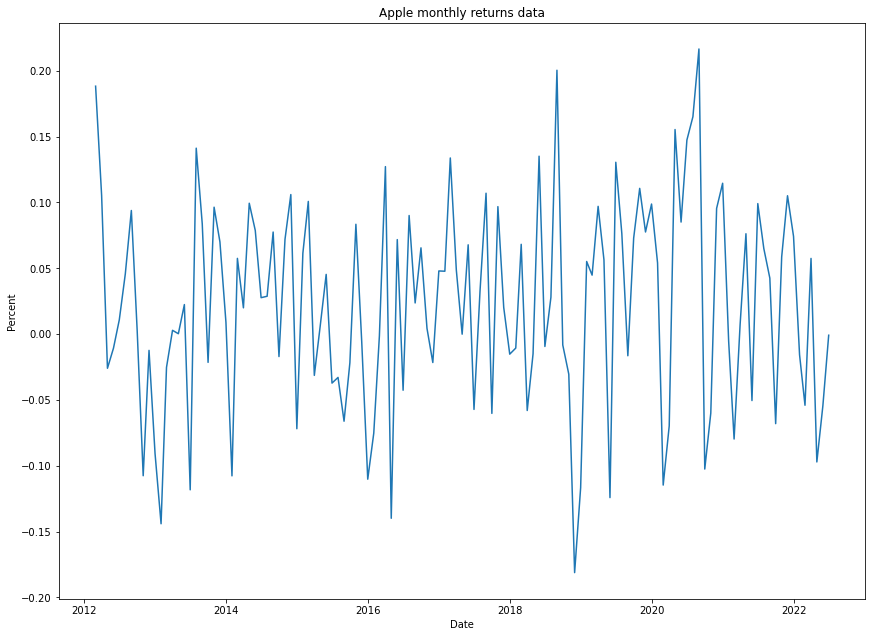

In [8]:
# plot monthly return
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(aapl_monthly_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Apple monthly returns data")
plt.show()

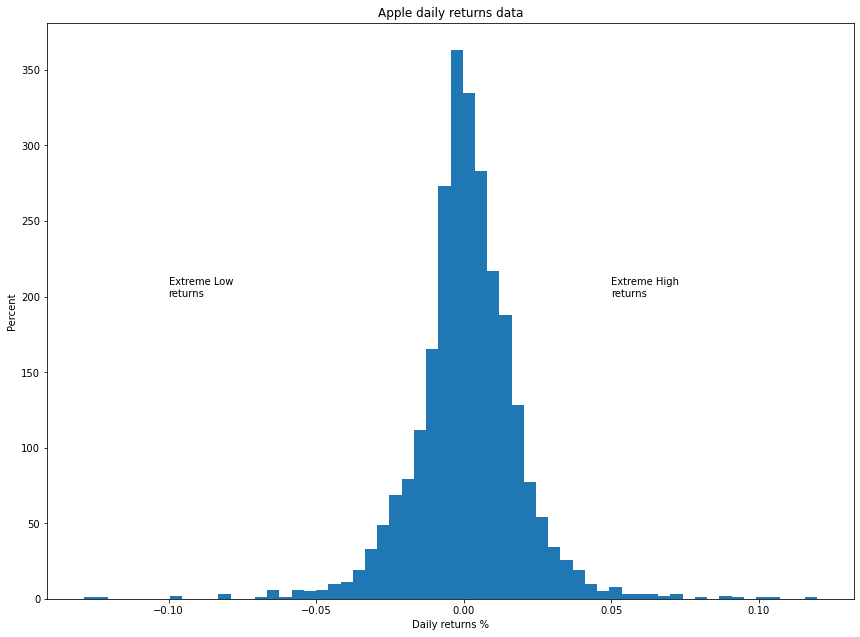

In [9]:
# plot distribution of returns
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
aapl_daily_returns.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Apple daily returns data")
ax1.text(-0.1,200,"Extreme Low\nreturns")
ax1.text(0.05,200,"Extreme High\nreturns")
plt.show()

In [10]:
aapl_cum_returns = (aapl_daily_returns + 1).cumprod()

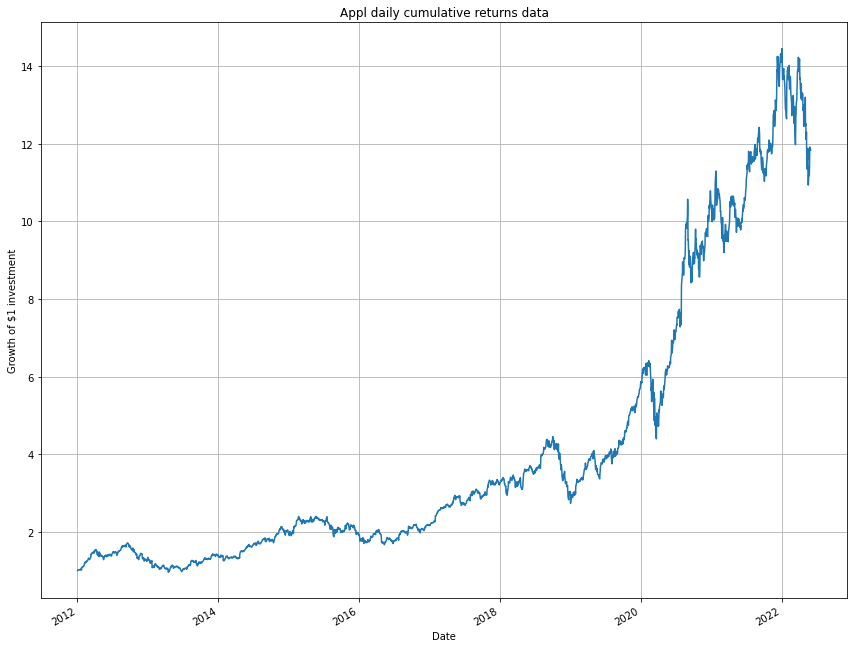

In [11]:
# plot the cumulative return
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
aapl_cum_returns.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("Appl daily cumulative returns data")
plt.grid()
plt.show()

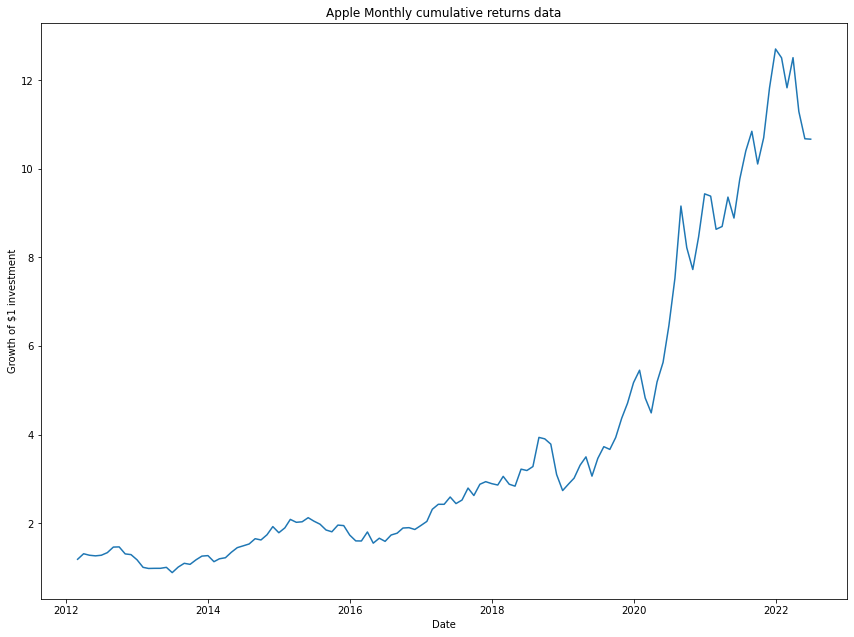

In [12]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
aapl_cum_returns = (aapl_monthly_returns + 1).cumprod()
ax1.plot(aapl_cum_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("Apple Monthly cumulative returns data")
plt.show()

#### EDA on multiple stocks

In [13]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]
prices = web.get_data_yahoo(tickers,
start = "2012-01-01",
end = "2022-06-01")

In [14]:
prices

Attributes   Adj Close                                                   \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA   
Date                                                                      
2012-01-03   12.557466   21.572889    8.951500   333.038025    5.616000   
2012-01-04   12.624949   22.080580    8.875500   334.474487    5.542000   
2012-01-05   12.765113   22.306225    8.880500   329.834839    5.424000   
2012-01-06   12.898552   22.652744    9.130500   325.335327    5.382000   
2012-01-09   12.878096   22.354578    8.928000   311.541534    5.450000   
...                ...         ...         ...          ...         ...   
2022-05-25  140.520004  262.519989  106.775002  2116.100098  658.799988   
2022-05-26  143.779999  265.899994  111.077499  2155.850098  707.729980   
2022-05-27  149.639999  273.239990  115.146500  2246.330078  759.630005   
2022-05-31  148.839996  271.869995  120.209503  2275.239990  758.260010   
2022-06-01  148.710007  272.420013  121.683998  2277.840088  740.369995   

Attributes       Close                                                   ...  \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA  ...   
Date                                                                     ...   
2012-01-03   14.686786   26.770000    8.951500   333.038025    5.616000  ...   
2012-01-04   14.765714   27.400000    8.875500   334.474487    5.542000  ...   
2012-01-05   14.929643   27.680000    8.880500   329.834839    5.424000  ...   
2012-01-06   15.085714   28.110001    9.130500   325.335327    5.382000  ...   
2012-01-09   15.061786   27.740000    8.928000   311.541534    5.450000  ...   
...                ...         ...         ...          ...         ...  ...   
2022-05-25  140.520004  262.519989  106.775002  2116.100098  658.799988  ...   
2022-05-26  143.779999  265.899994  111.077499  2155.850098  707.729980  ...   
2022-05-27  149.639999  273.239990  115.146500  2246.330078  759.630005  ...   
2022-05-31  148.839996  271.869995  120.209503  2275.239990  758.260010  ...   
2022-06-01  148.710007  272.420013  121.683998  2277.840088  740.369995  ...   

Attributes        Open                                                   \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA   
Date                                                                      
2012-01-03   14.621429   26.549999    8.794500   326.796783    5.788000   
2012-01-04   14.642857   26.820000    8.960500   332.847839    5.642000   
2012-01-05   14.819643   27.379999    8.797000   331.396393    5.552000   
2012-01-06   14.991786   27.530001    8.903500   329.904907    5.440000   
2012-01-09   15.196429   28.049999    9.138000   323.573578    5.400000   
...                ...         ...         ...          ...         ...   
2022-05-25  138.429993  258.140015  103.655502  2099.709961  623.849976   
2022-05-26  137.389999  262.269989  107.970001  2113.540039  661.419983   
2022-05-27  145.389999  268.480011  113.550003  2189.659912  723.250000   
2022-05-31  149.070007  272.529999  116.279999  2254.929932  773.840027   
2022-06-01  149.899994  275.200012  122.255997  2297.100098  755.159973   

Attributes       Volume                                                   
Symbols            AAPL        MSFT         AMZN       GOOGL        TSLA  
Date                                                                      
2012-01-03  302220800.0  64731500.0  102216000.0   7345647.0   4640500.0  
2012-01-04  260022000.0  80516100.0   84104000.0   5722272.0   3150500.0  
2012-01-05  271269600.0  56081400.0   76182000.0   6559234.0   5027500.0  
2012-01-06  318292800.0  99455500.0  140168000.0   5380414.0   4931500.0  
2012-01-09  394024400.0  59706800.0  101138000.0  11633555.0   4485000.0  
...                 ...         ...          ...         ...         ...  
2022-05-25   92482700.0  28547900.0   93120000.0   2012900.0  30713100.0  
2022-05-26   90601500.0  25

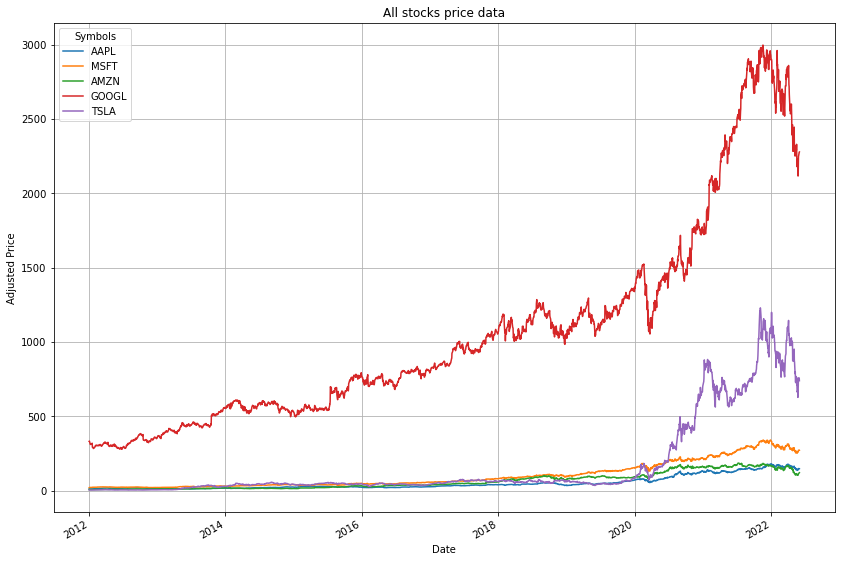

In [15]:
prices["Adj Close"].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted Price")
plt.title("All stocks price data")
plt.grid()
plt.show()

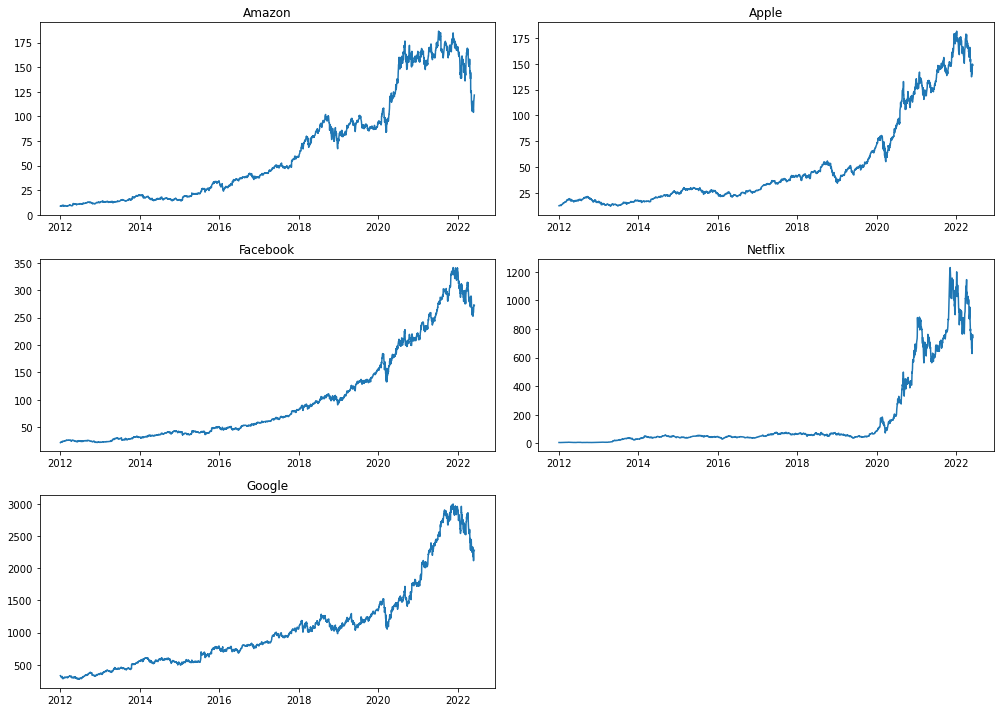

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax1.plot(prices['Adj Close']['AMZN'])
ax1.set_title("Amazon")
ax2.plot(prices['Adj Close']['AAPL'])
ax2.set_title("Apple")
ax3.plot(prices['Adj Close']['MSFT'])
ax3.set_title("Facebook")
ax4.plot(prices['Adj Close']['TSLA'])
ax4.set_title("Netflix")
ax5.plot(prices['Adj Close']['GOOGL'])
ax5.set_title("Google")
plt.tight_layout()
plt.show()

In [17]:
multpl_stock_daily_returns = prices['Adj Close'].pct_change()
multpl_stock_monthly_returns = prices['Adj Close'].resample('M').ffill().pct_change()

<Figure size 1008x720 with 0 Axes>

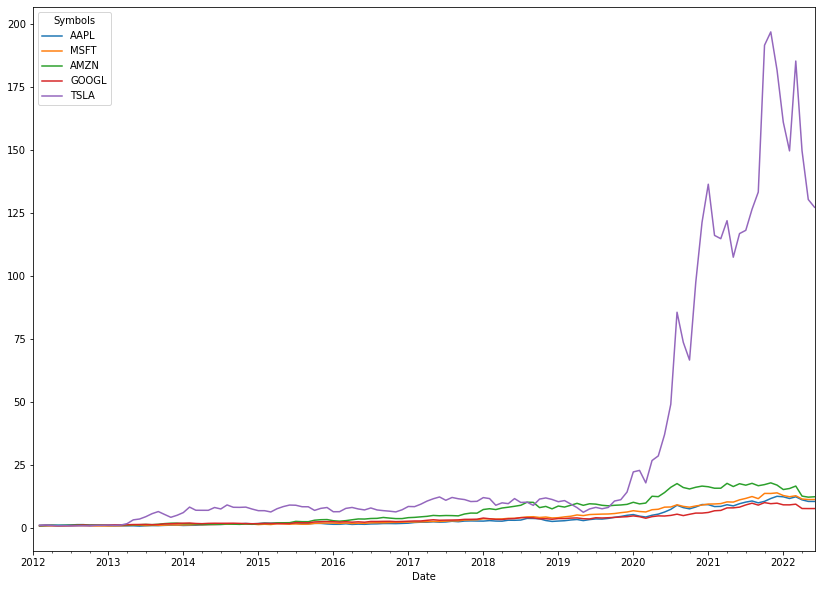

In [18]:
fig = plt.figure()
(multpl_stock_monthly_returns + 1).cumprod().plot()
plt.show()

In [19]:
multpl_stock_monthly_returns.mean()

Symbols
AAPL     0.022222
MSFT     0.021386
AMZN     0.023768
GOOGL    0.018596
TSLA     0.053560
dtype: float64

In [20]:
multpl_stock_monthly_returns.std()

Symbols
AAPL     0.079446
MSFT     0.059163
AMZN     0.082897
GOOGL    0.063708
TSLA     0.182193
dtype: float64

In [21]:
multpl_stock_monthly_returns.corr()

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Symbols,,,,,
AAPL,1.000000,0.496045,0.422425,0.393456,0.366162
MSFT,0.496045,1.000000,0.485885,0.552364,0.354191
AMZN,0.422425,0.485885,1.000000,0.575345,0.250196
GOOGL,0.393456,0.552364,0.575345,1.000000,0.280938
TSLA,0.366162,0.354191,0.250196,0.280938,1.000000


In [22]:
multpl_stock_monthly_returns.cov()

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Symbols,,,,,
AAPL,0.006312,0.002332,0.002782,0.001991,0.005300
MSFT,0.002332,0.003500,0.002383,0.002082,0.003818
AMZN,0.002782,0.002383,0.006872,0.003039,0.003779
GOOGL,0.001991,0.002082,0.003039,0.004059,0.003261
TSLA,0.005300,0.003818,0.003779,0.003261,0.033194


In [23]:
# example of equal weight for all 5 stocks
w = [0.2,0.2,0.2,0.2,0.2]

In [24]:
price_data = prices['Adj Close']
price_data

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Date,,,,,
2012-01-03,12.557466,21.572889,8.951500,333.038025,5.616000
2012-01-04,12.624949,22.080580,8.875500,334.474487,5.542000
2012-01-05,12.765113,22.306225,8.880500,329.834839,5.424000
2012-01-06,12.898552,22.652744,9.130500,325.335327,5.382000
2012-01-09,12.878096,22.354578,8.928000,311.541534,5.450000
...,...,...,...,...,...
2022-05-25,140.520004,262.519989,106.775002,2116.100098,658.799988
2022-05-26,143.779999,265.899994,111.077499,2155.850098,707.729980
2022-05-27,149.639999,273.239990,115.146500,2246.330078,759.630005


In [25]:
ret_data = price_data.pct_change()[1:]
ret_data.head()

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Date,,,,,
2012-01-04,0.005374,0.023534,-0.008490,0.004313,-0.013177
2012-01-05,0.011102,0.010219,0.000563,-0.013871,-0.021292
2012-01-06,0.010453,0.015535,0.028152,-0.013642,-0.007743
2012-01-09,-0.001586,-0.013162,-0.022178,-0.042399,0.012635
2012-01-10,0.003581,0.003605,0.004368,0.001093,0.013578


In [26]:
weighted_returns = (w * ret_data)
weighted_returns.head()

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Date,,,,,
2012-01-04,0.001075,0.004707,-0.001698,0.000863,-0.002635
2012-01-05,0.002220,0.002044,0.000113,-0.002774,-0.004258
2012-01-06,0.002091,0.003107,0.005630,-0.002728,-0.001549
2012-01-09,-0.000317,-0.002632,-0.004436,-0.008480,0.002527
2012-01-10,0.000716,0.000721,0.000874,0.000219,0.002716


In [27]:
port_ret = weighted_returns.sum(axis=1)
port_ret

Date
2012-01-04    0.002311
2012-01-05   -0.002656
2012-01-06    0.006551
2012-01-09   -0.013338
2012-01-10    0.005245
                ...   
2022-05-25    0.017045
2022-05-26    0.033885
2022-05-27    0.044059
2022-05-31    0.008935
2022-06-01   -0.001807
Length: 2620, dtype: float64

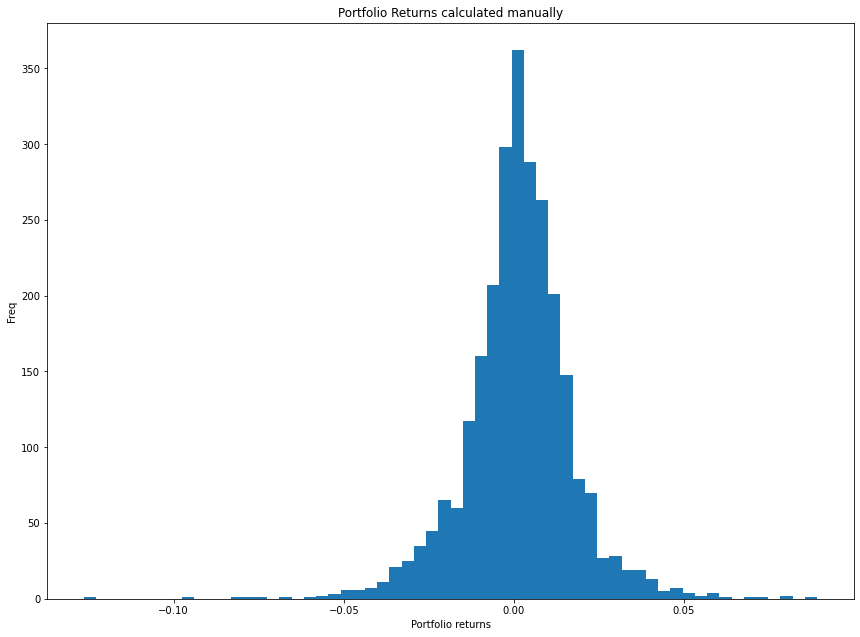

In [28]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.hist(port_ret, bins = 60)
ax1.set_xlabel('Portfolio returns')
ax1.set_ylabel("Freq")
ax1.set_title("Portfolio Returns calculated manually")
plt.show(); 

In [29]:
cumulative_ret = (port_ret + 1).cumprod()

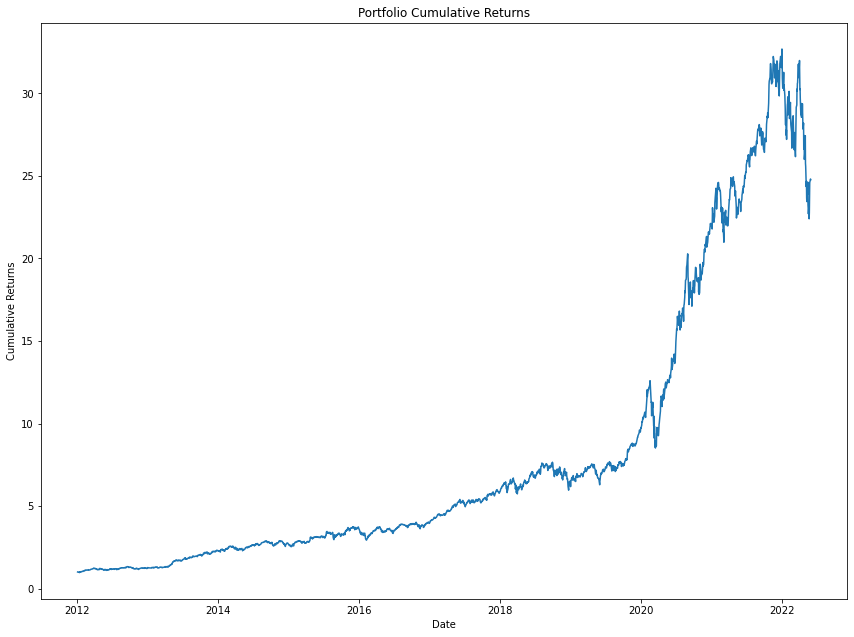

In [30]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_ret)
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Portfolio Cumulative Returns")
plt.show();

In [31]:
geometric_port_return = np.prod(port_ret + 1) ** (252/port_ret.shape[0]) - 1
geometric_port_return

0.3616793928038524

In [32]:
annual_std = np.std(port_ret) * np.sqrt(252)
annual_std

0.25185806089653456

In [33]:
port_sharpe_ratio = geometric_port_return / annual_std
port_sharpe_ratio

1.436044538405437

In [34]:
benchmark_price = web.get_data_yahoo('SPY',
                               start = '2012-01-01',
                               end = '2022-06-01')
                               
benchmark_ret = benchmark_price["Adj Close"].pct_change()[1:]

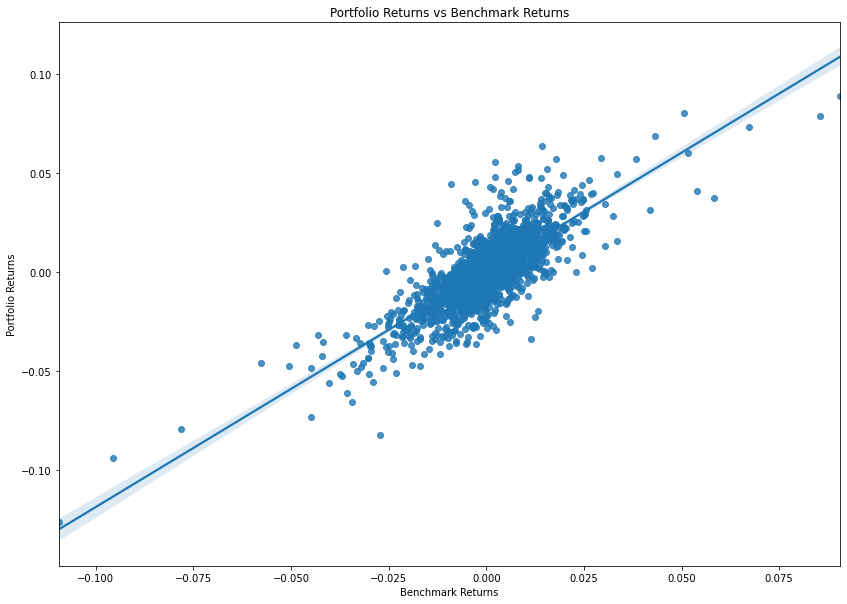

In [35]:
sns.regplot(benchmark_ret.values,
port_ret.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio Returns")
plt.title("Portfolio Returns vs Benchmark Returns")
plt.show()

In [36]:
(beta, alpha) = stats.linregress(benchmark_ret.values,
                port_ret.values)[0:2]
                
print("The portfolio beta is", round(beta, 4))

The portfolio beta is 1.1948


In [37]:
print("The portfolio alpha is", round(alpha,5))

The portfolio alpha is 0.00067


#### Exploring Morningstar datasets

In [38]:
df_totalReturns = pd.read_csv('data/MS_totalReturns.csv', nrows=503)
df_totalReturns

,Name,Ticker,Return Date \n(Daily),Total Ret \nYTD \n(Daily) \nUSD,Total Ret \n1 Day \n(Daily) \nUSD,Total Ret \n1 Wk \n(Daily) \nUSD,Total Ret \n1 Mo \n(Daily) \nUSD,Total Ret \n2 Mo \n(Daily) \nUSD,Total Ret \n3 Mo \n(Daily) \nUSD,Total Ret \n6 Mo \n(Daily) \nUSD,...,Total Ret \n1 Mo \n(Qtr-End) \nUSD,Total Ret \n2 Mo \n(Qtr-End) \nUSD,Total Ret \n3 Mo \n(Qtr-End) \nUSD,Total Ret \n6 Mo \n(Qtr-End) \nUSD,Total Ret \nYTD \n(Qtr-End) \nUSD,Total Ret \n1 Yr \n(Qtr-End) \nUSD,Total Ret \nAnnlzd 2 Yr \n(Qtr-End) \nUSD,Total Ret \nAnnlzd 3 Yr \n(Qtr-End) \nUSD,Total Ret \nAnnlzd 5 Yr \n(Qtr-End) \nUSD,Total Ret \nAnnlzd 10 Yr \n(Qtr-End) \nUSD
0,3M Co,MMM,2022-07-05,-25.58,0.56,-0.86,-11.48,-12.55,-12.22,-26.35,...,-13.32,-9.24,-12.08,-25.47,-25.47,-31.86,-4.84,-5.33,-5.40,6.97
1,A.O. Smith Corp,AOS,2022-07-05,-32.50,2.43,4.01,-5.67,-2.61,-11.81,-30.63,...,-9.05,-6.42,-13.98,-35.66,-35.66,-22.59,9.79,6.98,1.01,17.44
2,Abbott Laboratories,ABT,2022-07-05,-21.67,-0.83,2.18,-6.24,-3.28,-8.13,-18.44,...,-7.50,-4.27,-7.81,-22.13,-22.13,-4.69,10.73,10.50,18.95,9.11
3,AbbVie Inc,ABBV,2022-07-05,16.04,0.08,0.94,4.59,1.15,-4.95,15.64,...,3.93,4.28,-4.65,15.47,15.47,41.11,29.21,32.30,19.33,NaN
4,Abiomed Inc,ABMD,2022-07-05,-28.54,0.82,3.04,-2.13,-5.73,-20.45,-24.11,...,-6.14,-13.63,-25.28,-31.09,-31.09,-20.70,1.22,-1.69,11.55,26.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Yum Brands Inc,YUM,2022-07-05,-14.68,0.53,3.39,-1.09,1.97,0.22,-12.58,...,-6.55,-2.50,-3.75,-17.43,-17.43,0.54,16.32,2.55,10.63,9.21
499,Zebra Technologies Corp Class A,ZBRA,2022-07-05,-49.21,1.00,0.04,-9.69,-13.06,-28.65,-45.84,...,-13.08,-20.48,-28.95,-50.61,-50.61,-44.48,7.17,11.95,23.94,23.94
500,Zimmer Biomet Holdings Inc,ZBH,2022-07-05,-13.08,-0.35,0.39,-11.19,-12.58,-17.04,-15.07,...,-12.40,-12.80,-17.67,-14.52,-14.52,-32.18,-3.99,-1.95,-2.54,6.18
501,Zions Bancorp NA,ZION,2022-07-05,-17.92,-0.58,-3.06,-9.66,-10.36,-20.09,-21.72,...,-10.76,-9.26,-21.78,-18.21,-18.21,-0.83,25.77,6.24,5.38,11.57


In [39]:
df_rating = pd.read_csv('data/MS_rating.csv', nrows=503)
df_rating

,Name,Ticker,Date: Morningstar Rating,Morningstar \nRating \nOverall,Morningstar \nFair Value \nStatus,Morningstar Fair Value Per Share,Fair Value Uncertainty,Stock Capital Allocation \nRating,Date: Economic Moat,Economic Moat,...,Probability of Default,Solvency Score,Bear Market Rank Decile,Business Risk \nPillar,Solvency Score \nPillar,Cash Flow Cushion \nPillar,Stress Test Pillar,Momentum Score %,Consider Buying,Consider Selling
0,3M Co,MMM,7/5/2022,4.0,Active,186,Medium,Standard,7/5/2022,Wide,...,0.0,341.37,9.0,NaN,NaN,NaN,NaN,22.61,130.2,251.1
1,A.O. Smith Corp,AOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,211.71,8.0,NaN,NaN,NaN,NaN,35.70,NaN,NaN
2,Abbott Laboratories,ABT,7/5/2022,3.0,Active,104,Medium,Standard,7/5/2022,Narrow,...,0.0,300.44,5.0,NaN,NaN,NaN,NaN,47.99,72.8,140.4
3,AbbVie Inc,ABBV,7/5/2022,2.0,Active,125,High,Standard,7/5/2022,Narrow,...,0.0,490.74,8.0,NaN,NaN,NaN,NaN,93.37,75,193.75
4,Abiomed Inc,ABMD,NaN,NaN,NaN,NaN,NaN,NaN,12/31/2013,None,...,0.0,NaN,7.0,NaN,NaN,NaN,NaN,28.87,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Yum Brands Inc,YUM,7/5/2022,3.0,Active,125,Medium,Standard,7/5/2022,Wide,...,0.0,469.86,5.0,NaN,NaN,NaN,NaN,44.57,87.5,168.75
499,Zebra Technologies Corp Class A,ZBRA,7/5/2022,4.0,Active,449,High,Standard,7/5/2022,Narrow,...,0.0,278.15,8.0,NaN,NaN,NaN,NaN,8.65,269.4,695.95
500,Zimmer Biomet Holdings Inc,ZBH,7/5/2022,5.0,Active,175,Medium,Exemplary,7/5/2022,Wide,...,0.0,544.71,8.0,NaN,NaN,NaN,NaN,34.74,122.5,236.25
501,Zions Bancorp NA,ZION,7/5/2022,4.0,Active,70,Medium,Standard,7/5/2022,None,...,0.1,NaN,9.0,NaN,NaN,NaN,NaN,66.27,49,94.5


In [40]:
df_snapshot = pd.read_csv('data/MS_snapshot.csv', nrows=503)
df_snapshot

,Name,Ticker,SEC CIK,Exchange,Exchange Country,Business Country,Company Name,Company Id,SecId,CUSIP,...,ICB Supersector,ICB Sector,ICB Subsector,Market Industry Code - JP,Market Industry Name - JP,Local Short Trading Name,Local Legal Trading Name,ESG Risk \nRating Assessment,Submarket,ADR
0,3M Co,MMM,66740,"New York Stock Exchange, Inc.",United States,United States,3M Co,0C0000095Q,0P0000000I,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,A.O. Smith Corp,AOS,91142,"New York Stock Exchange, Inc.",United States,United States,A.O. Smith Corp,0C00000964,0P0000000Y,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,Abbott Laboratories,ABT,1800,"New York Stock Exchange, Inc.",United States,United States,Abbott Laboratories,0C0000096K,0P0000003P,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,AbbVie Inc,ABBV,1551152,"New York Stock Exchange, Inc.",United States,United States,AbbVie Inc,0C00009SSX,0P0000XPGW,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,Abiomed Inc,ABMD,815094,Nasdaq - All Markets,United States,United States,Abiomed Inc,0C0000096R,0P0000003X,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Yum Brands Inc,YUM,1041061,"New York Stock Exchange, Inc.",United States,United States,Yum Brands Inc,0C000009RZ,0P0000061H,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
499,Zebra Technologies Corp Class A,ZBRA,877212,Nasdaq - All Markets,United States,United States,Zebra Technologies Corp,0C000009S6,0P0000061P,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
500,Zimmer Biomet Holdings Inc,ZBH,1136869,"New York Stock Exchange, Inc.",United States,United States,Zimmer Biomet Holdings Inc,0C000009SE,0P0000061X,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
501,Zions Bancorp NA,ZION,109380,Nasdaq - All Markets,United States,United States,Zions Bancorp NA,0C000009SF,0P0000061Y,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [41]:
df_snapshot=df_snapshot.dropna(axis=1,how='all')

In [42]:
df_snapshot

,Name,Ticker,SEC CIK,Exchange,Exchange Country,Business Country,Company Name,Company Id,SecId,ISIN,...,Russell Industry,Equity \nStyle Box (Long),Stock Type,Analyst Name,Analysis Date,Security Type,Equity Profile \nReport Date,IPO Date,IPO Offer Price,ADR
0,3M Co,MMM,66740,"New York Stock Exchange, Inc.",United States,United States,3M Co,0C0000095Q,0P0000000I,NaN,...,Diversified manufacturing operations,Large Value,High Yield,Joshua Aguilar,4/27/2022,Common Stock,NaN,1/14/1946,NaN,No
1,A.O. Smith Corp,AOS,91142,"New York Stock Exchange, Inc.",United States,United States,A.O. Smith Corp,0C00000964,0P0000000Y,NaN,...,Building: Climate control,Mid Blend,Cyclical,NaN,NaN,Common Stock,NaN,9/7/1984,NaN,No
2,Abbott Laboratories,ABT,1800,"New York Stock Exchange, Inc.",United States,United States,Abbott Laboratories,0C0000096K,0P0000003P,NaN,...,Pharmaceuticals,Large Blend,Aggressive Growth,Debbie S. Wang,1/24/2022,Common Stock,NaN,4/19/1949,NaN,No
3,AbbVie Inc,ABBV,1551152,"New York Stock Exchange, Inc.",United States,United States,AbbVie Inc,0C00009SSX,0P0000XPGW,NaN,...,Pharmaceuticals,Large Value,Aggressive Growth,"Damien Conover, CFA",6/3/2022,Common Stock,NaN,12/10/2012,NaN,No
4,Abiomed Inc,ABMD,815094,Nasdaq - All Markets,United States,United States,Abiomed Inc,0C0000096R,0P0000003X,NaN,...,Medical & dental instruments & supplies,Mid Growth,Slow Growth,NaN,NaN,Common Stock,5/11/2012,7/30/1987,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Yum Brands Inc,YUM,1041061,"New York Stock Exchange, Inc.",United States,United States,Yum Brands Inc,0C000009RZ,0P0000061H,NaN,...,Restaurants,Mid Blend,Cyclical,Sean Dunlop,5/12/2022,Common Stock,NaN,9/17/1997,NaN,No
499,Zebra Technologies Corp Class A,ZBRA,877212,Nasdaq - All Markets,United States,United States,Zebra Technologies Corp,0C000009S6,0P0000061P,NaN,...,Office supplies and equipment,Mid Blend,Cyclical,William Kerwin,2/10/2022,Common Stock,5/11/2012,8/15/1991,NaN,No
500,Zimmer Biomet Holdings Inc,ZBH,1136869,"New York Stock Exchange, Inc.",United States,United States,Zimmer Biomet Holdings Inc,0C000009SE,0P0000061X,NaN,...,Medical & dental instruments & supplies,Mid Blend,Slow Growth,Debbie S. Wang,3/1/2022,Common Stock,NaN,8/7/2001,NaN,No
501,Zions Bancorp NA,ZION,109380,Nasdaq - All Markets,United States,United States,Zions Bancorp NA,0C000009SF,0P0000061Y,NaN,...,Banks: Diversified,Mid Value,Cyclical,"Eric Compton, CFA",5/4/2022,Common Stock,5/11/2012,3/26/1990,NaN,No


In [43]:
industry_df = df_snapshot[['Name', 'Sector']].copy()
industry_df

,Name,Sector
0,3M Co,Industrials
1,A.O. Smith Corp,Industrials
2,Abbott Laboratories,Healthcare
3,AbbVie Inc,Healthcare
4,Abiomed Inc,Healthcare
...,...,...
498,Yum Brands Inc,Consumer Cyclical
499,Zebra Technologies Corp Class A,Technology
500,Zimmer Biomet Holdings Inc,Healthcare
501,Zions Bancorp NA,Financial Services


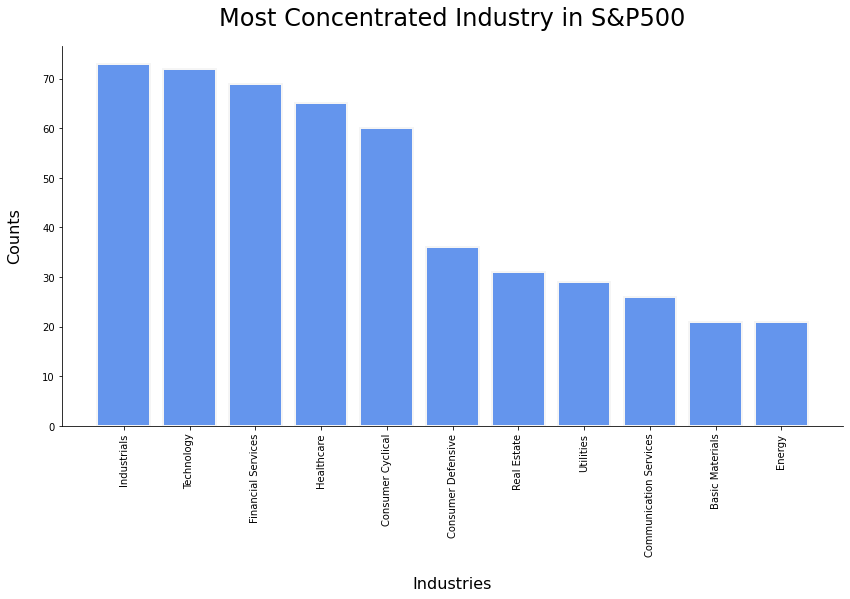

In [44]:
def make_bar_chart(df, attribute, bar_color='cornflowerblue', edge_color='whitesmoke', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = df[attribute].value_counts().index
        ys = df[attribute].value_counts().values
    else:
        xs = df[attribute].value_counts().sort_index().index
        ys = df[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=90)
    
    
make_bar_chart(industry_df, 'Sector', title='Most Concentrated Industry in S&P500', xlab='Industries', ylab='Counts')

In [45]:
pd.set_option('display.max_columns', None)
df_complete = industry_df.merge(df_rating, on = 'Name')
df_complete

,Name,Sector,Ticker,Date: Morningstar Rating,Morningstar \nRating \nOverall,Morningstar \nFair Value \nStatus,Morningstar Fair Value Per Share,Fair Value Uncertainty,Stock Capital Allocation \nRating,Date: Economic Moat,Economic Moat,Moat Trend,Moat Source \n- Cost Advantage,Moat Source \n- Efficient Scale,Moat Source \n- Intangible Assets,Moat Source \n- Network Effect,Moat Source \n- Switch Cost,Morningstar Quantitative Rating Date,Morningstar Quantitative Rating Overall,Date: Quantitative Valuation,Quantitative Moat,Quantitative Valuation,Quantitative Valuation Uncertainty,Quantitative Financial Health,Quantitative Fair Value \nEstimate \nUSD,Morningstar \nCredit Rating \nDate,Morningstar \nCredit Rating,Date: Morningstar Grades,Growth Grade,Profitability Grade,Financial Health Grade,Probability of Default,Solvency Score,Bear Market Rank Decile,Business Risk \nPillar,Solvency Score \nPillar,Cash Flow Cushion \nPillar,Stress Test Pillar,Momentum Score %,Consider Buying,Consider Selling
0,3M Co,Industrials,MMM,7/5/2022,4.0,Active,186,Medium,Standard,7/5/2022,Wide,Stable,Yes,No,Yes,No,No,7/5/2022,5,7/5/2022,Wide,Undervalued,High,Moderate,165.28,NaN,NaN,7/5/2022,C,C,B,0.0,341.37,9.0,NaN,NaN,NaN,NaN,22.61,130.2,251.1
1,A.O. Smith Corp,Industrials,AOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7/5/2022,5,7/5/2022,Wide,Undervalued,High,Strong,70.81,NaN,NaN,7/5/2022,C,C,B,0.0,211.71,8.0,NaN,NaN,NaN,NaN,35.70,NaN,NaN
2,Abbott Laboratories,Healthcare,ABT,7/5/2022,3.0,Active,104,Medium,Standard,7/5/2022,Narrow,Stable,No,No,Yes,No,No,7/5/2022,3,7/5/2022,Wide,Fairly Valued,High,Strong,111.75,NaN,NaN,7/5/2022,C,B,A,0.0,300.44,5.0,NaN,NaN,NaN,NaN,47.99,72.8,140.4
3,AbbVie Inc,Healthcare,ABBV,7/5/2022,2.0,Active,125,High,Standard,7/5/2022,Narrow,Negative,No,No,Yes,No,No,7/5/2022,3,7/5/2022,Wide,Overvalued,Medium,Moderate,142.9,NaN,NaN,7/5/2022,B,NaN,B,0.0,490.74,8.0,NaN,NaN,NaN,NaN,93.37,75,193.75
4,Abiomed Inc,Healthcare,ABMD,NaN,NaN,NaN,NaN,NaN,NaN,12/31/2013,None,NaN,NaN,NaN,NaN,NaN,NaN,7/5/2022,3,7/5/2022,Narrow,Fairly Valued,High,Moderate,258.62,NaN,NaN,7/5/2022,B,D,A,0.0,NaN,7.0,NaN,NaN,NaN,NaN,28.87,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Yum Brands Inc,Consumer Cyclical,YUM,7/5/2022,3.0,Active,125,Medium,Standard,7/5/2022,Wide,Negative,Yes,No,Yes,No,No,7/5/2022,3,7/5/2022,Wide,Fairly Valued,Medium,Moderate,119.1,NaN,NaN,7/5/2022,C,NaN,B,0.0,469.86,5.0,NaN,NaN,NaN,NaN,44.57,87.5,168.75
499,Zebra Technologies Corp Class A,Technology,ZBRA,7/5/2022,4.0,Active,449,High,Standard,7/5/2022,Narrow,Stable,No,No,No,No,Yes,7/5/2022,3,7/5/2022,Narrow,Undervalued,High,Moderate,435.44,NaN,NaN,7/5/2022,C,A,B,0.0,278.15,8.0,NaN,NaN,NaN,NaN,8.65,269.4,695.95
500,Zimmer Biomet Holdings Inc,Healthcare,ZBH,7/5/2022,5.0,Active,175,Medium,Exemplary,7/5/2022,Wide,Stable,No,No,Yes,No,Yes,7/5/2022,5,7/5/2022,Wide,Undervalued,High,Moderate,141.48,NaN,NaN,7/5/2022,C,D,B,0.0,544.71,8.0,NaN,NaN,NaN,NaN,34.74,122.5,236.25
501,Zions Bancorp NA,Financial Services,ZION,7/5/2022,4.0,Active,70,Medium,Standard,7/5/2022,None,Stable,No,No,No,No,No,7/5/2022,4,7/5/2022,None,Undervalued,High,Strong,65.65,NaN,NaN,7/5/2022,C,C,D,0.1,NaN,9.0,NaN,NaN,NaN,NaN,66.27,49,94.5


In [46]:
sector_means = df_complete.groupby('Sector').agg('mean')
sector_means = sector_means.reset_index([0, 'Sector'])
sector_means_sorted = sector_means.sort_values(by = 'Morningstar \nRating \nOverall', ascending=False)
sector_means_sorted['Morningstar Overall Rating'] = sector_means_sorted['Morningstar \nRating \nOverall']*0.7 + sector_means_sorted['Morningstar Quantitative Rating Overall']*0.3
sector_means_sorted_complete = sector_means_sorted[['Sector', 'Morningstar Overall Rating']]
sector_mean_value = sector_means_sorted_complete['Morningstar Overall Rating'].mean()
sector_means_sorted_complete

,Sector,Morningstar Overall Rating
1,Communication Services,4.134615
2,Consumer Cyclical,3.829000
9,Technology,3.863021
5,Financial Services,3.679710
0,Basic Materials,3.794643
8,Real Estate,3.659677
7,Industrials,3.558314
6,Healthcare,3.235142
4,Energy,3.157143
3,Consumer Defensive,2.838333


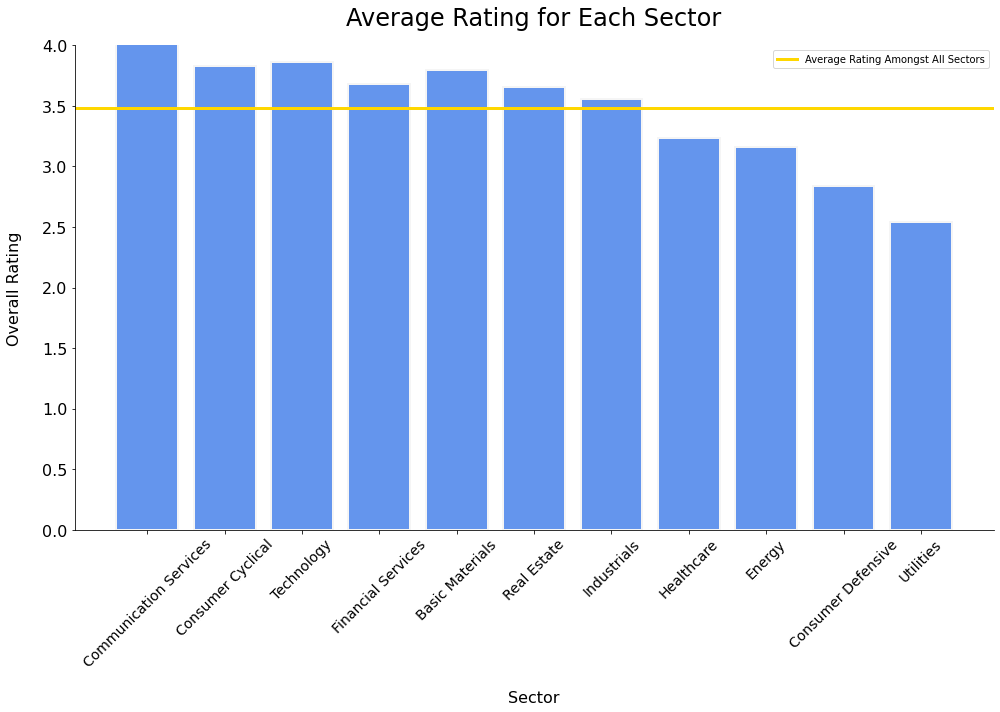

In [47]:
title, xlab, ylab, = 'Average Rating for Each Sector', 'Sector', 'Overall Rating'

fig, ax = plt.subplots(figsize=(14, 10))
ax.bar(x = sector_means_sorted_complete['Sector'], height = sector_means_sorted_complete['Morningstar Overall Rating'], edgecolor='whitesmoke', color = 'cornflowerblue', linewidth=2)
plt.axhline(y=sector_mean_value,linewidth=3, color='gold')
plt.ylim([0,4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(title, fontsize=24, pad=20)
ax.set_xlabel(xlab, fontsize=16, labelpad=20)
ax.set_ylabel(ylab, fontsize=16, labelpad=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Images/sector_rating', bbox_inches='tight');
plt.legend(['Average Rating Amongst All Sectors'])

In [48]:
df_rating_complete = df_complete[['Name', 'Sector', 'Ticker', 'Morningstar \nRating \nOverall', 'Morningstar Quantitative Rating Overall']]
df_rating_complete

,Name,Sector,Ticker,Morningstar \nRating \nOverall,Morningstar Quantitative Rating Overall
0,3M Co,Industrials,MMM,4.0,5
1,A.O. Smith Corp,Industrials,AOS,NaN,5
2,Abbott Laboratories,Healthcare,ABT,3.0,3
3,AbbVie Inc,Healthcare,ABBV,2.0,3
4,Abiomed Inc,Healthcare,ABMD,NaN,3
...,...,...,...,...,...
498,Yum Brands Inc,Consumer Cyclical,YUM,3.0,3
499,Zebra Technologies Corp Class A,Technology,ZBRA,4.0,3
500,Zimmer Biomet Holdings Inc,Healthcare,ZBH,5.0,5
501,Zions Bancorp NA,Financial Services,ZION,4.0,4


#### First Tryout on Predicting Stock Price using Logistic Modeling

This is a tryout to model the probability of stock moving up or down the next day.

In [49]:
# Using an example of S&P500 
data = yf.download("^GSPC", start='2012-01-01', end='2022-01-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000
...,...,...,...,...,...,...
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2264120000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2217050000
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2369370000


In [50]:
df = data['Adj Close'].pct_change() * 100
df

Date
2012-01-03         NaN
2012-01-04    0.018792
2012-01-05    0.294372
2012-01-06   -0.253696
2012-01-09    0.226160
                ...   
2021-12-27    1.383894
2021-12-28   -0.101015
2021-12-29    0.140190
2021-12-30   -0.298976
2021-12-31   -0.262618
Name: Adj Close, Length: 2517, dtype: float64

In [51]:
df = df.rename('Today')
df

Date
2012-01-03         NaN
2012-01-04    0.018792
2012-01-05    0.294372
2012-01-06   -0.253696
2012-01-09    0.226160
                ...   
2021-12-27    1.383894
2021-12-28   -0.101015
2021-12-29    0.140190
2021-12-30   -0.298976
2021-12-31   -0.262618
Name: Today, Length: 2517, dtype: float64

In [52]:
df = df.reset_index()
df

,Date,Today
0,2012-01-03,NaN
1,2012-01-04,0.018792
2,2012-01-05,0.294372
3,2012-01-06,-0.253696
4,2012-01-09,0.226160
...,...,...
2512,2021-12-27,1.383894
2513,2021-12-28,-0.101015
2514,2021-12-29,0.140190
2515,2021-12-30,-0.298976


In [53]:
# creating lags
for i in range(1,6):
    df['Lag '+str(i)] = df['Today'].shift(i)
df


,Date,Today,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
0,2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-04,0.018792,NaN,NaN,NaN,NaN,NaN
2,2012-01-05,0.294372,0.018792,NaN,NaN,NaN,NaN
3,2012-01-06,-0.253696,0.294372,0.018792,NaN,NaN,NaN
4,2012-01-09,0.226160,-0.253696,0.294372,0.018792,NaN,NaN
...,...,...,...,...,...,...,...
2512,2021-12-27,1.383894,0.622370,1.018020,1.777793,-1.138806,-1.028768
2513,2021-12-28,-0.101015,1.383894,0.622370,1.018020,1.777793,-1.138806
2514,2021-12-29,0.140190,-0.101015,1.383894,0.622370,1.018020,1.777793
2515,2021-12-30,-0.298976,0.140190,-0.101015,1.383894,0.622370,1.018020


In [54]:
df['Volume'] = data.Volume.shift(1).values/100_000_000
df['Volume']

0           NaN
1       39.4371
2       35.9258
3       43.1595
4       36.5683
         ...   
2512    21.9463
2513    22.6412
2514    22.1705
2515    23.6937
2516    23.9099
Name: Volume, Length: 2517, dtype: float64

In [55]:
df = df.dropna()
df

,Date,Today,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Volume
6,2012-01-11,0.030960,0.888577,0.226160,-0.253696,0.294372,0.018792,42.2196
7,2012-01-12,0.233661,0.030960,0.888577,0.226160,-0.253696,0.294372,39.6812
8,2012-01-13,-0.494792,0.233661,0.030960,0.888577,0.226160,-0.253696,40.1989
9,2012-01-17,0.355295,-0.494792,0.233661,0.030960,0.888577,0.226160,36.9237
10,2012-01-18,1.110793,0.355295,-0.494792,0.233661,0.030960,0.888577,40.1049
...,...,...,...,...,...,...,...,...
2512,2021-12-27,1.383894,0.622370,1.018020,1.777793,-1.138806,-1.028768,21.9463
2513,2021-12-28,-0.101015,1.383894,0.622370,1.018020,1.777793,-1.138806,22.6412
2514,2021-12-29,0.140190,-0.101015,1.383894,0.622370,1.018020,1.777793,22.1705
2515,2021-12-30,-0.298976,0.140190,-0.101015,1.383894,0.622370,1.018020,23.6937


In [56]:
# creating direction column
df['Direction'] = [1 if i > 0 else 0 for i in df['Today']]
df

,Date,Today,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Volume,Direction
6,2012-01-11,0.030960,0.888577,0.226160,-0.253696,0.294372,0.018792,42.2196,1
7,2012-01-12,0.233661,0.030960,0.888577,0.226160,-0.253696,0.294372,39.6812,1
8,2012-01-13,-0.494792,0.233661,0.030960,0.888577,0.226160,-0.253696,40.1989,0
9,2012-01-17,0.355295,-0.494792,0.233661,0.030960,0.888577,0.226160,36.9237,1
10,2012-01-18,1.110793,0.355295,-0.494792,0.233661,0.030960,0.888577,40.1049,1
...,...,...,...,...,...,...,...,...,...
2512,2021-12-27,1.383894,0.622370,1.018020,1.777793,-1.138806,-1.028768,21.9463,1
2513,2021-12-28,-0.101015,1.383894,0.622370,1.018020,1.777793,-1.138806,22.6412,0
2514,2021-12-29,0.140190,-0.101015,1.383894,0.622370,1.018020,1.777793,22.1705,1
2515,2021-12-30,-0.298976,0.140190,-0.101015,1.383894,0.622370,1.018020,23.6937,0


In [57]:
# add a constant to run the model
df = sm.add_constant(df)
df

,const,Date,Today,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Volume,Direction
6,1.0,2012-01-11,0.030960,0.888577,0.226160,-0.253696,0.294372,0.018792,42.2196,1
7,1.0,2012-01-12,0.233661,0.030960,0.888577,0.226160,-0.253696,0.294372,39.6812,1
8,1.0,2012-01-13,-0.494792,0.233661,0.030960,0.888577,0.226160,-0.253696,40.1989,0
9,1.0,2012-01-17,0.355295,-0.494792,0.233661,0.030960,0.888577,0.226160,36.9237,1
10,1.0,2012-01-18,1.110793,0.355295,-0.494792,0.233661,0.030960,0.888577,40.1049,1
...,...,...,...,...,...,...,...,...,...,...
2512,1.0,2021-12-27,1.383894,0.622370,1.018020,1.777793,-1.138806,-1.028768,21.9463,1
2513,1.0,2021-12-28,-0.101015,1.383894,0.622370,1.018020,1.777793,-1.138806,22.6412,0
2514,1.0,2021-12-29,0.140190,-0.101015,1.383894,0.622370,1.018020,1.777793,22.1705,1
2515,1.0,2021-12-30,-0.298976,0.140190,-0.101015,1.383894,0.622370,1.018020,23.6937,0


In [58]:
X = df[['const', 'Lag 1',  'Lag 2',  'Lag 3',  'Lag 4',  'Lag 5', 'Volume']]
y = df.Direction

In [59]:
model = sm.Logit(y,X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.685058
         Iterations 5


In [60]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 2511
Model:                          Logit   Df Residuals:                     2504
Method:                           MLE   Df Model:                            6
Date:                Wed, 13 Jul 2022   Pseudo R-squ.:                0.004483
Time:                        15:58:07   Log-Likelihood:                -1720.2
converged:                       True   LL-Null:                       -1727.9
Covariance Type:            nonrobust   LLR p-value:                   0.01675
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1859      0.176      1.056      0.291      -0.159       0.531
Lag 1         -0.1372      0.042     -3.259      0.001      -0.220      -0.055
Lag 2          0.0278      0.041      0.672      0.502      -0.053       0.109
Lag 3         -0.0345      0.042     -0.824      0.410      -0.116       0.048
Lag 4         -0.0406      0.041     -0.983      0.326      -0.121       0.040
Lag 5         -0.0525      0.041     -1.274      0.203      -0.133       0.028
Volume         0.0008      0.005      0.176      0.860      -0.008       0.010
==============================================================================
"""

In [61]:
prediction = result.predict(X)
prediction

6       0.525060
7       0.556143
8       0.540117
9       0.560004
10      0.524959
          ...   
2512    0.546269
2513    0.496089
2514    0.524983
2515    0.514156
2516    0.541113
Length: 2511, dtype: float64

In [62]:
def confusion_matrix(act, pred):
    predtrans = ['Up' if i > 0.5 else 'Down' for i in pred]
    actuals = ['Up' if i > 0 else 'Down' for i in act]
    confusion_matrix = pd.crosstab(pd.Series(actuals), 
                                   pd.Series(predtrans),
                                  rownames = ['Actual'],
                                  colnames = ['Predicted'])
    return confusion_matrix

In [63]:
confusion_matrix(y, prediction)

Predicted,Down,Up
Actual,,
Down,77,1053
Up,58,1323


In [64]:
len(df)
(77+1323)/2511

0.5575467941059339

In [65]:
# split train and test data
X_train = df[df.Date.dt.year < 2018][['const', 'Lag 1',  'Lag 2',  'Lag 3',  'Lag 4',  'Lag 5', 'Volume']]
y_train = df[df.Date.dt.year < 2018]['Direction']
X_test = df[df.Date.dt.year >= 2018][['const', 'Lag 1',  'Lag 2',  'Lag 3',  'Lag 4',  'Lag 5', 'Volume']]
y_test = df[df.Date.dt.year >= 2018]['Direction']

In [66]:
model = sm.Logit(y_train, X_train)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.687313
         Iterations 4


In [67]:
prediction = result.predict(X_test)
confusion_matrix(y_test, prediction)

Predicted,Down,Up
Actual,,
Down,64,374
Up,53,517


In [68]:
len(X_test)
(64+517)/1008

0.5763888888888888

It looks like the test score is even higher than training score, meaning our model is decent up to this point. Theoretically speaking, we have an accuracy of 57.6% predicting tomorrow market's up and down

#### Predicting stock movement range for next 12 months by using ARIMA model

Now let's move to a longer period of prediction

In [69]:
amzn = pd.read_csv('data/AMZN.csv')
amzn

,Date,Open,High,Low,Close,Adj Close,Volume
0,6/1/1997,0.075521,0.085417,0.068750,0.077083,0.077083,1063272000
1,7/1/1997,0.077083,0.128646,0.075521,0.119792,0.119792,2172288000
2,8/1/1997,0.117188,0.120833,0.096875,0.116927,0.116927,638136000
3,9/1/1997,0.117188,0.240625,0.115625,0.216927,0.216927,2157240000
4,10/1/1997,0.221875,0.275000,0.176042,0.254167,0.254167,2103744000
...,...,...,...,...,...,...,...
268,10/1/2019,87.300003,89.942497,84.252998,88.833000,88.833000,1407210000
269,11/1/2019,89.400497,91.234497,86.135498,90.040001,90.040001,1041524000
270,12/1/2019,90.220001,95.070000,86.750000,92.391998,92.391998,1362992000
271,1/1/2020,93.750000,102.786003,90.766998,100.435997,100.435997,1693966000


In [70]:
df = amzn[['Date','Close']]
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df_close = df['Close']
df_close

Date
1997-06-01      0.077083
1997-07-01      0.119792
1997-08-01      0.116927
1997-09-01      0.216927
1997-10-01      0.254167
                 ...    
2019-10-01     88.833000
2019-11-01     90.040001
2019-12-01     92.391998
2020-01-01    100.435997
2020-02-01     94.187500
Name: Close, Length: 273, dtype: float64

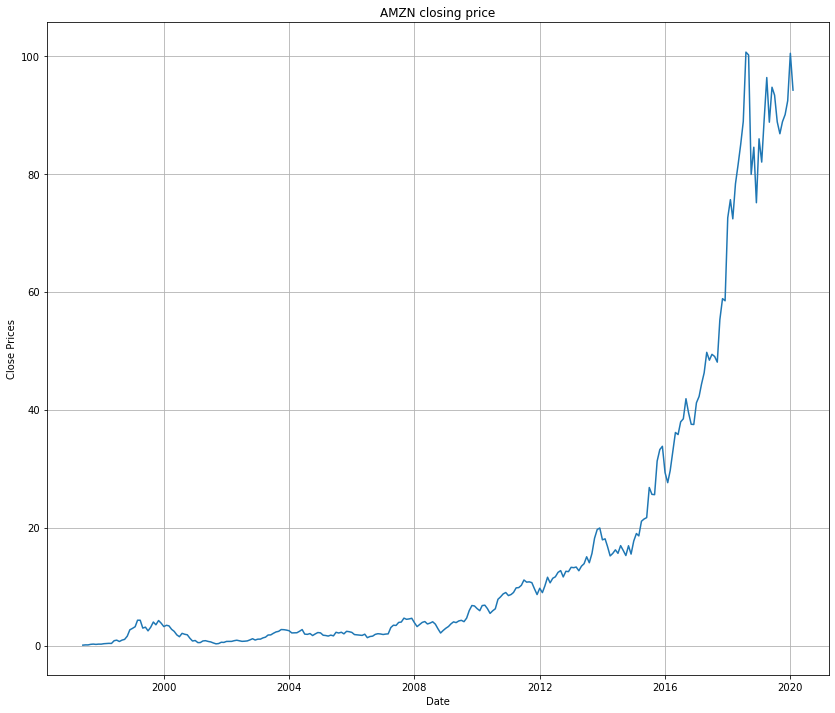

In [71]:
#plot close price
plt.figure(figsize=(14, 12))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('AMZN closing price')
plt.show()

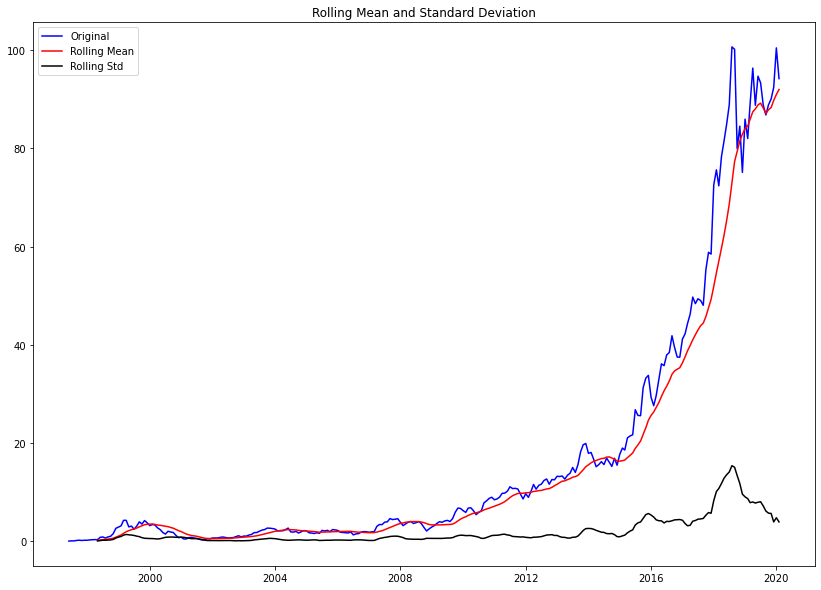

Results of dickey fuller test
Test Statistics                  2.252029
p-value                          0.998923
No. of lags used                 7.000000
Number of observations used    265.000000
critical value (1%)             -3.455270
critical value (5%)             -2.872509
critical value (10%)            -2.572615
dtype: float64


In [72]:
#Test for staionarity

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1008x720 with 0 Axes>

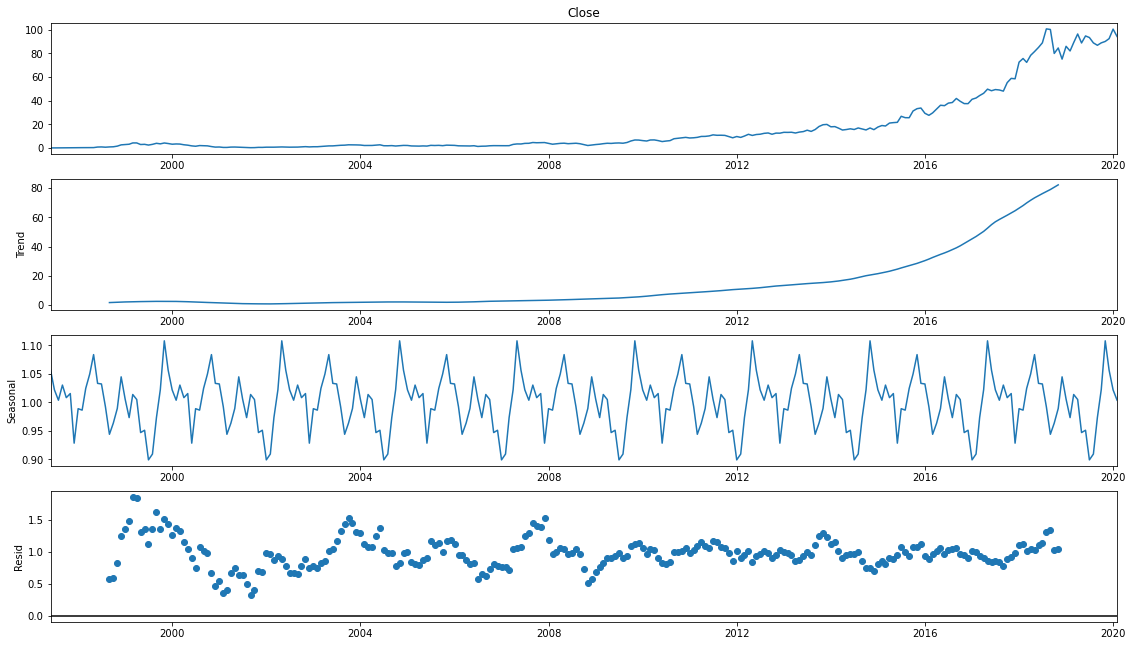

In [73]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


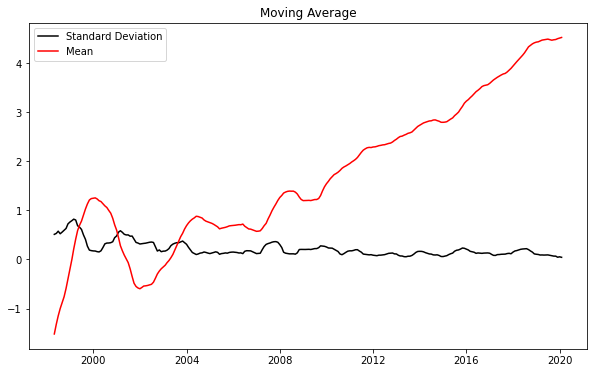

In [74]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

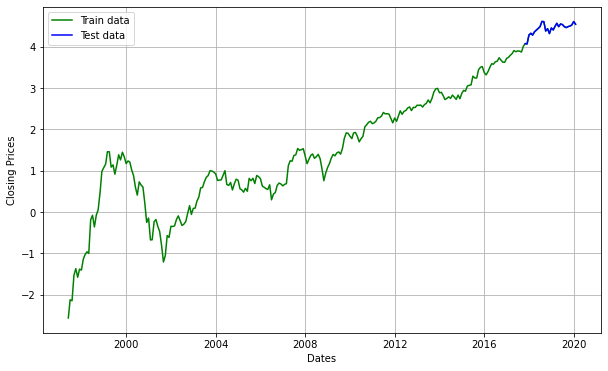

In [75]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-202.706, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.604, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-202.650, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-199.631, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-201.584, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.309 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  242
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 103.353
Date:                Wed, 13 Jul 2022   AIC                           -202.706
Time:                        15:58:08   BIC                           -195.736
Sample:                             0   HQIC                          -199.898
                                - 242                                       

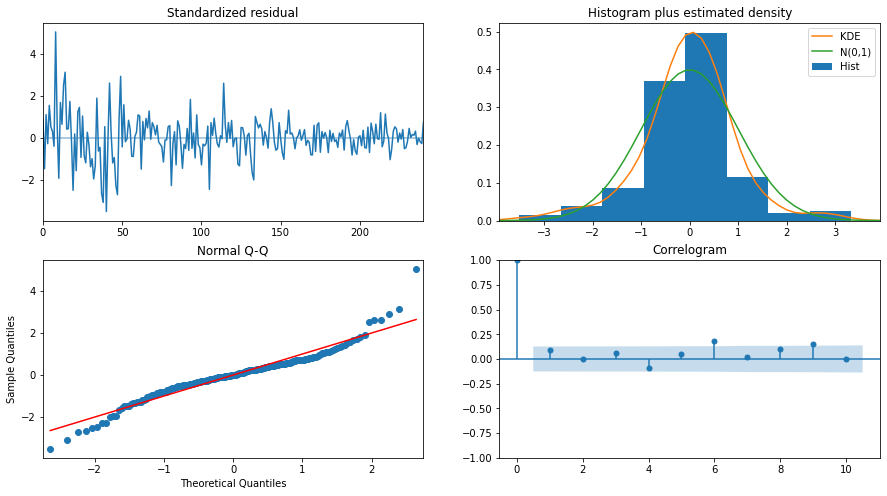

In [76]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [77]:
# Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  242
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 100.815
Date:                Wed, 13 Jul 2022   AIC                           -199.631
Time:                        15:58:09   BIC                           -196.146
Sample:                    09-01-1997   HQIC                          -198.227
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0254      0.001     18.516      0.000       0.023       0.028
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):               140.18
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

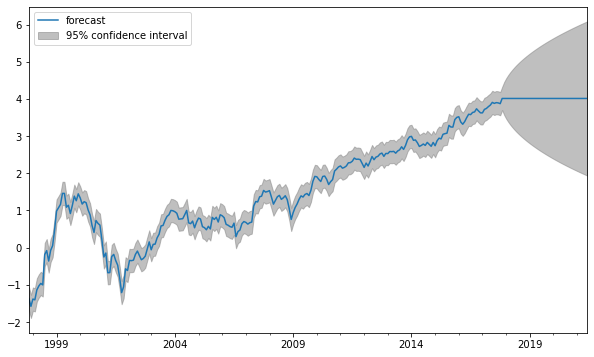

In [78]:
plot_predict(fitted, start=2, end=len(df)+12)
plt.legend(loc='upper left')
# plt.plot(test_data)
plt.show()


### Utilizin XGBoost Algorithm to Predict Price Pattern

In [79]:
# settign Input params for later modeling
stk_path = "data/AAPL.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14


In [80]:
# Function we would use later
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''
    
    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [81]:
# loading data
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
df

,date,open,high,low,close,adj_close,volume,month
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.557465,302220800,1
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.624950,260022000,1
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.765113,271269600,1
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.898556,318292800,1
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.878098,394024400,1
...,...,...,...,...,...,...,...,...
2624,2022-06-07,144.350006,149.000000,144.100006,148.710007,148.710007,67808200,6
2625,2022-06-08,148.580002,149.869995,147.460007,147.960007,147.960007,53950200,6
2626,2022-06-09,147.080002,147.949997,142.529999,142.639999,142.639999,69473000,6
2627,2022-06-10,140.279999,140.759995,137.059998,137.130005,137.130005,91437900,6


Text(0, 0.5, 'USD')

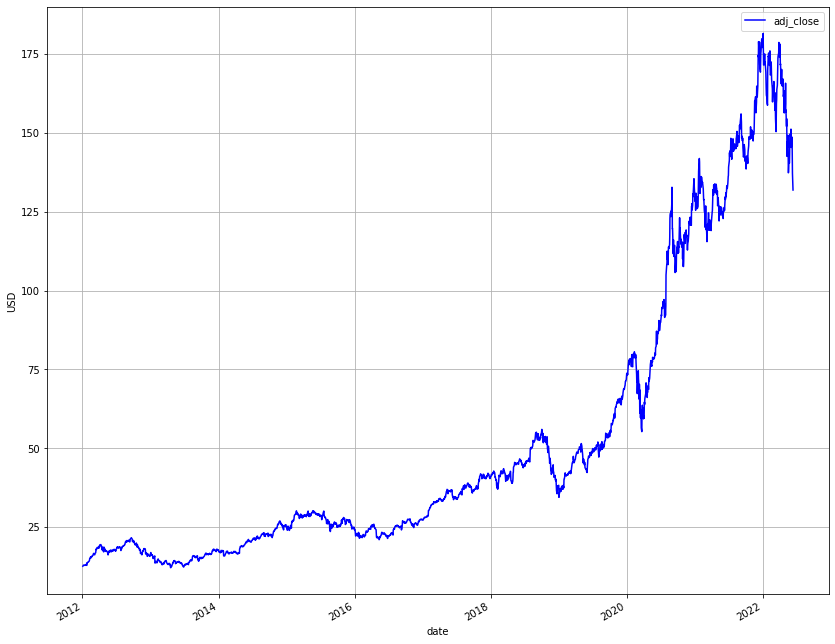

In [82]:
rcParams['figure.figsize'] = 14, 12

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

#### Feature Engineering

In [83]:
# Add 2 features
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)
df

,date,adj_close,volume,month,range_hl,range_oc
0,2012-01-03,12.557465,302220800,1,0.125000,-0.065357
1,2012-01-04,12.624950,260022000,1,0.192857,-0.122857
2,2012-01-05,12.765113,271269600,1,0.210000,-0.110000
3,2012-01-06,12.898556,318292800,1,0.126071,-0.093928
4,2012-01-09,12.878098,394024400,1,0.228572,0.134643
...,...,...,...,...,...,...
2624,2022-06-07,148.710007,67808200,6,4.899994,-4.360001
2625,2022-06-08,147.960007,53950200,6,2.409988,0.619995
2626,2022-06-09,142.639999,69473000,6,5.419998,4.440003
2627,2022-06-10,137.130005,91437900,6,3.699997,3.149994


Create lags for features

In [84]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [85]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
df

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2012-01-06,12.898556,318292800,1,0.126071,-0.093928,3,12.765113,0.210000,-0.110000,271269600.0,12.624950,0.192857,-0.122857,260022000.0,12.557465,0.125000,-0.065357,302220800.0
4,2012-01-09,12.878098,394024400,1,0.228572,0.134643,4,12.898556,0.126071,-0.093928,318292800.0,12.765113,0.210000,-0.110000,271269600.0,12.624950,0.192857,-0.122857,260022000.0
5,2012-01-10,12.924206,258196400,1,0.160715,0.095357,5,12.878098,0.228572,0.134643,394024400.0,12.898556,0.126071,-0.093928,318292800.0,12.765113,0.210000,-0.110000,271269600.0
6,2012-01-11,12.903136,215084800,1,0.126429,0.004643,6,12.924206,0.160715,0.095357,258196400.0,12.878098,0.228572,0.134643,394024400.0,12.898556,0.126071,-0.093928,318292800.0
7,2012-01-12,12.867714,212587200,1,0.148214,0.031786,7,12.903136,0.126429,0.004643,215084800.0,12.924206,0.160715,0.095357,258196400.0,12.878098,0.228572,0.134643,394024400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,2022-06-07,148.710007,67808200,6,4.899994,-4.360001,2624,146.139999,3.670013,0.890000,71598400.0,145.380005,3.509994,1.519989,88471400.0,151.210007,4.410003,-3.380005,72348100.0
2625,2022-06-08,147.960007,53950200,6,2.409988,0.619995,2625,148.710007,4.899994,-4.360001,67808200.0,146.139999,3.670013,0.890000,71598400.0,145.380005,3.509994,1.519989,88471400.0
2626,2022-06-09,142.639999,69473000,6,5.419998,4.440003,2626,147.960007,2.409988,0.619995,53950200.0,148.710007,4.899994,-4.360001,67808200.0,146.139999,3.670013,0.890000,71598400.0
2627,2022-06-10,137.130005,91437900,6,3.699997,3.149994,2627,142.639999,5.419998,4.440003,69473000.0,147.960007,2.409988,0.619995,53950200.0,148.710007,4.899994,-4.360001,67808200.0


In [86]:
cols_list = [
            "adj_close",
            "range_hl",
            "range_oc",
            "volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2012-01-06,12.898556,318292800,1,0.126071,-0.093928,3,12.765113,0.210000,-0.110000,271269600.0,12.624950,0.192857,-0.122857,260022000.0,12.557465,0.125000,-0.065357,302220800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-09,12.878098,394024400,1,0.228572,0.134643,4,12.898556,0.126071,-0.093928,318292800.0,12.765113,0.210000,-0.110000,271269600.0,12.624950,0.192857,-0.122857,260022000.0,12.898556,NaN,0.126071,NaN,-0.093928,NaN,3.182928e+08,NaN
5,2012-01-10,12.924206,258196400,1,0.160715,0.095357,5,12.878098,0.228572,0.134643,394024400.0,12.898556,0.126071,-0.093928,318292800.0,12.765113,0.210000,-0.110000,271269600.0,12.888327,0.014466,0.177321,0.072479,0.020358,0.161624,3.561586e+08,5.355033e+07
6,2012-01-11,12.903136,215084800,1,0.126429,0.004643,6,12.924206,0.160715,0.095357,258196400.0,12.878098,0.228572,0.134643,394024400.0,12.898556,0.126071,-0.093928,318292800.0,12.900287,0.023103,0.171786,0.052140,0.045357,0.122214,3.235045e+08,6.806382e+07
7,2012-01-12,12.867714,212587200,1,0.148214,0.031786,7,12.903136,0.126429,0.004643,215084800.0,12.924206,0.160715,0.095357,258196400.0,12.878098,0.228572,0.134643,394024400.0,12.901813,0.023082,0.171905,0.051983,0.078214,0.066674,2.891019e+08,9.338740e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,2022-06-07,148.710007,67808200,6,4.899994,-4.360001,2624,146.139999,3.670013,0.890000,71598400.0,145.380005,3.509994,1.519989,88471400.0,151.210007,4.410003,-3.380005,72348100.0,147.576670,3.169424,3.863337,0.480140,-0.323339,2.665826,7.747263e+07,9.532584e+06
2625,2022-06-08,147.960007,53950200,6,2.409988,0.619995,2625,148.710007,4.899994,-4.360001,67808200.0,146.139999,3.670013,0.890000,71598400.0,145.380005,3.509994,1.519989,88471400.0,146.743337,1.745062,4.026667,0.760544,-0.650004,3.228356,7.595933e+07,1.100024e+07
2626,2022-06-09,142.639999,69473000,6,5.419998,4.440003,2626,147.960007,2.409988,0.619995,53950200.0,148.710007,4.899994,-4.360001,67808200.0,146.139999,3.670013,0.890000,71598400.0,147.603338,1.321607,3.659998,1.245033,-0.950002,2.956230,6.445227e+07,9.290396e+06
2627,2022-06-10,137.130005,91437900,6,3.699997,3.149994,2627,142.639999,5.419998,4.440003,69473000.0,147.960007,2.409988,0.619995,53950200.0,148.710007,4.899994,-4.360001,67808200.0,146.436671,3.309330,4.243327,1.608866,0.233332,4.412726,6.374380e+07,8.522256e+06


#### Train-Test Split into Train, Dev and Test

In [87]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1576
num_cv = 525
num_test = 525
train.shape = (1576, 27)
cv.shape = (525, 27)
train_cv.shape = (2101, 27)
test.shape = (525, 27)


In [88]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [2.41979232e+01 2.41795680e+01 4.61765745e-01 1.79252157e-03
 2.70241734e+08 2.41613820e+01 4.61535958e-01 1.74788008e-03
 2.70349790e+08 2.41430302e+01 4.61223458e-01 1.74606726e-03
 2.70469451e+08]
scaler.var_ = [6.37744684e+01 6.36628571e+01 8.23115337e-02 1.10326406e-01
 3.91841816e+16 6.35615621e+01 8.23518483e-02 1.10334392e-01
 3.91635600e+16 6.34563522e+01 8.24081794e-02 1.10334630e-01
 3.91486066e+16]
train_scaled.shape = (1576, 13)
train_scaled.shape = (1576, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.414916,-1.430580,-0.877539,-0.336568,0.005193,-1.447019,-0.936261,-0.375128,-0.052187,-1.454386,-1.171232,-0.202016,0.160474,2012-01-06,1
1,-1.417478,-1.413855,-1.170076,-0.288181,0.242744,-1.429438,-0.876523,-0.336422,0.004648,-1.445914,-0.934852,-0.375122,-0.052802,2012-01-09,1
2,-1.411704,-1.416419,-0.812805,0.399966,0.625323,-1.412700,-1.168989,-0.288036,0.242261,-1.428319,-0.875135,-0.336416,0.004044,2012-01-10,1
3,-1.414343,-1.410641,-1.049323,0.281690,-0.060850,-1.415267,-0.811806,0.400086,0.624942,-1.411567,-1.167501,-0.288030,0.241703,2012-01-11,1
4,-1.418778,-1.413281,-1.168829,0.008582,-0.278641,-1.409483,-1.048266,0.281814,-0.061412,-1.414136,-0.810440,0.400091,0.624456,2012-01-12,1


#### Scaling the train, dev and test set

In [89]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 3.14370681e+01  3.14069879e+01  6.36269784e-01 -1.92646259e-02
  2.35530881e+08  3.13763990e+01  6.35316837e-01 -2.00870214e-02
  2.35577392e+08  3.13453549e+01  6.34209031e-01 -1.92959015e-02
  2.35651773e+08]
scaler_train_cv.var_ = [2.36414371e+02 2.35635750e+02 3.39916440e-01 2.56001653e-01
 3.39922199e+16 2.34817997e+02 3.38852693e-01 2.54750386e-01
 3.39899508e+16 2.33960662e+02 3.37403713e-01 2.53363178e-01
 3.39882355e+16]
train_cv_scaled.shape = (2101, 13)
train_cv_scaled.shape = (2101, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.205696,-1.214420,-0.731136,-0.179331,0.193843,-1.223684,-0.760096,-0.203615,0.132589,-1.228306,-0.876640,-0.091509,0.361084,2012-01-06,1
1,-1.207027,-1.205727,-0.875091,-0.147566,0.448891,-1.214537,-0.730646,-0.178141,0.193597,-1.223894,-0.759819,-0.205743,0.132189,2012-01-09,1
2,-1.204028,-1.207060,-0.699282,0.304186,0.859650,-1.205829,-0.874827,-0.146299,0.448654,-1.214731,-0.730306,-0.180200,0.193198,2012-01-10,1
3,-1.205398,-1.204056,-0.815670,0.226540,0.122935,-1.207164,-0.698742,0.306561,0.859427,-1.206006,-0.874796,-0.148270,0.448261,2012-01-11,1
4,-1.207702,-1.205429,-0.874477,0.047251,-0.110897,-1.204155,-0.815312,0.228725,0.122687,-1.207344,-0.698333,0.305828,0.859045,2012-01-12,1


In [90]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1579,2018-04-13,1.015322,-0.983939,-0.031384,-1.006472,0.013071,0.993400,-1.151940,0.645074,0.506866,-0.507188,-0.644777,1.151965
1580,2018-04-16,0.807395,0.311205,-1.118600,-0.468755,-0.679516,1.148271,0.872885,-1.091083,0.218198,1.140042,-0.411185,-0.728857
1581,2018-04-17,1.083337,-0.195569,-0.887768,-1.153673,0.619016,0.534657,-0.640196,1.152331,-0.512135,-0.902966,1.074772,-0.171807
1582,2018-04-18,1.100281,-0.246766,-0.853515,0.973408,-1.024624,0.051216,-1.021462,0.044404,0.977058,0.839795,-1.106234,0.266439
1583,2018-04-19,0.416271,0.724624,-1.140894,-0.005696,1.002836,-0.997140,0.959085,-1.036424,0.077339,-0.702518,1.144891,-0.442373


In [91]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2104,2020-05-14,-1.007165,0.014488,0.992677,1.117837,-0.809578,-0.308260,0.438984,0.705424,-1.144408,1.104593,-0.260910,-0.843683
2105,2020-05-15,0.003544,-1.001768,0.998223,-0.680200,1.148182,-0.467981,-1.140462,0.413677,0.726785,-0.648617,1.151637,-0.503019
2106,2020-05-18,-0.549227,1.154251,-0.605024,-0.677322,-0.471231,1.148554,-0.752740,-0.381942,1.134682,-0.402475,-0.736051,1.138526
2107,2020-05-19,1.120178,-0.802786,-0.317392,-1.113366,0.291520,0.821846,1.049800,-0.941361,-0.108440,-1.124334,0.789995,0.334339
2108,2020-05-20,0.319043,0.801550,-1.120593,-0.850764,-0.250747,1.101511,0.925473,0.135281,-1.060754,-1.011545,0.023505,0.988040


In [92]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1576, 12)
y_train.shape = (1576,)
X_cv.shape = (525, 12)
y_cv.shape = (525,)
X_train_cv.shape = (2101, 12)
y_train_cv.shape = (2101,)
X_sample.shape = (525, 12)
y_sample.shape = (525,)


In [93]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1576, 12)
y_train_scaled.shape = (1576,)
X_cv_scaled.shape = (525, 12)
X_train_cv_scaled.shape = (2101, 12)
y_train_cv_scaled.shape = (2101,)
X_sample_scaled.shape = (525, 12)


#### EDA to show datasets after data preprocessing

Text(0.5, 1.0, 'Without scaling')

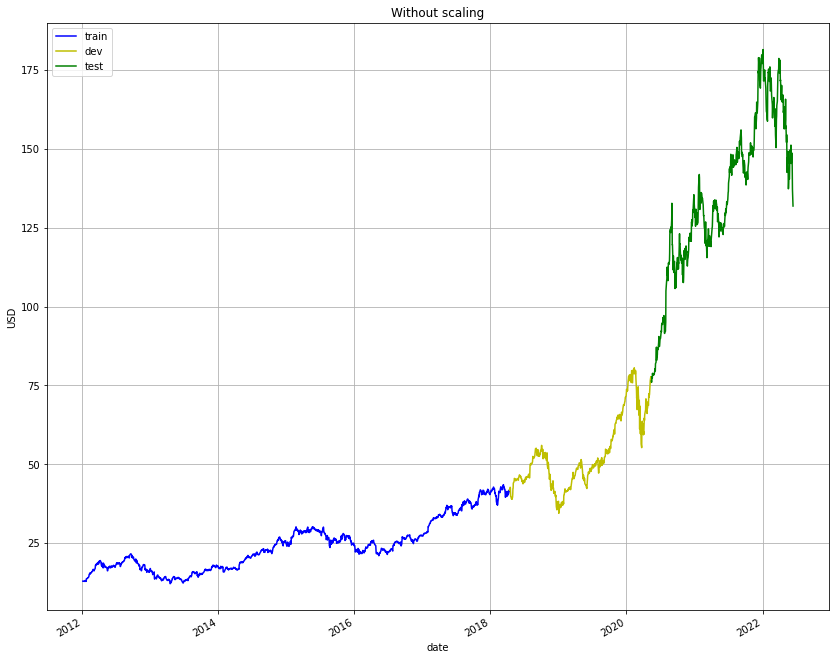

In [94]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 14, 12

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

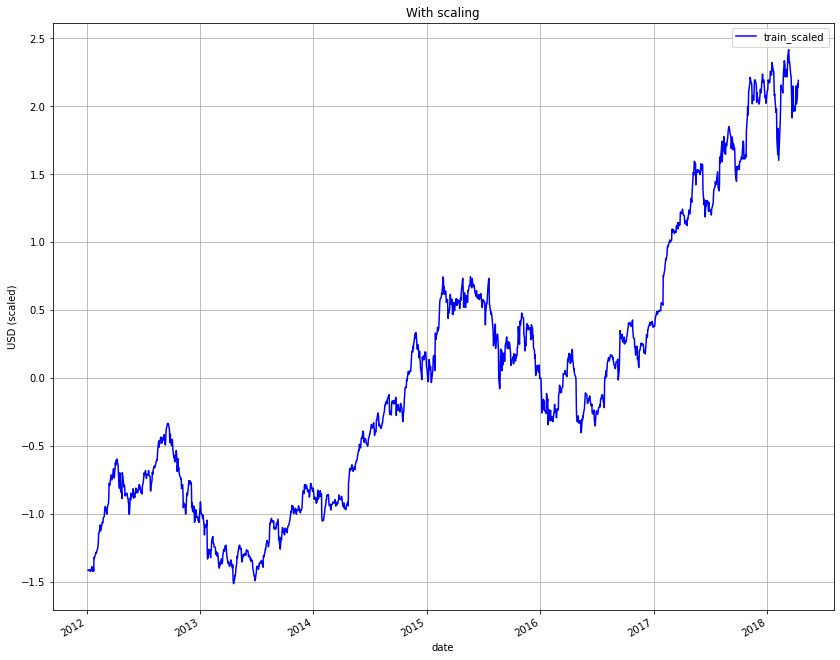

In [95]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 14, 12 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [96]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Quantitative Modeling

#### Predicting on training set

In [97]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.290
MAPE on train set = 0.912%


Text(0.5, 1.0, 'Without scaling')

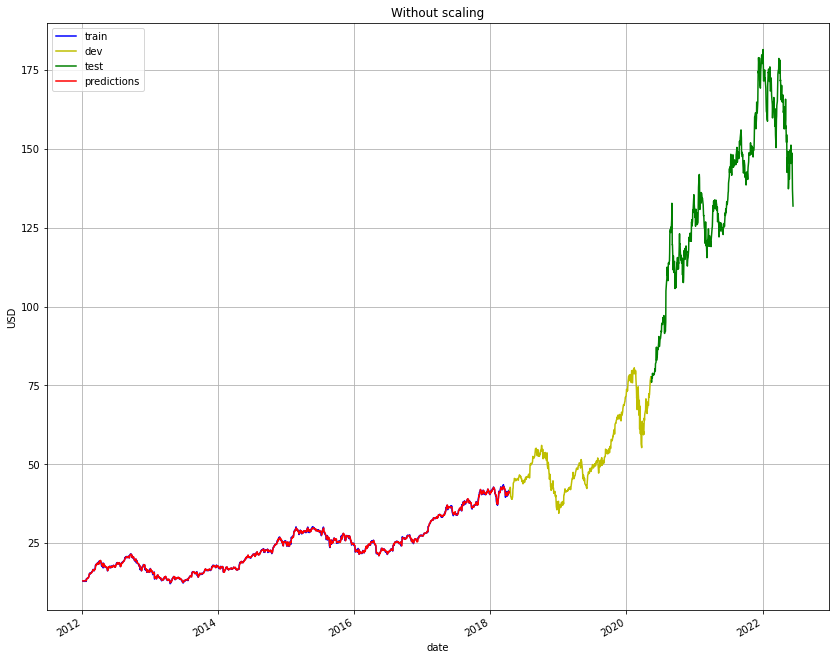

In [98]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 14, 12 

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

#### Prediction on dev set

In [99]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 1.268
MAPE on dev set = 1.478%


Text(0, 0.5, 'USD')

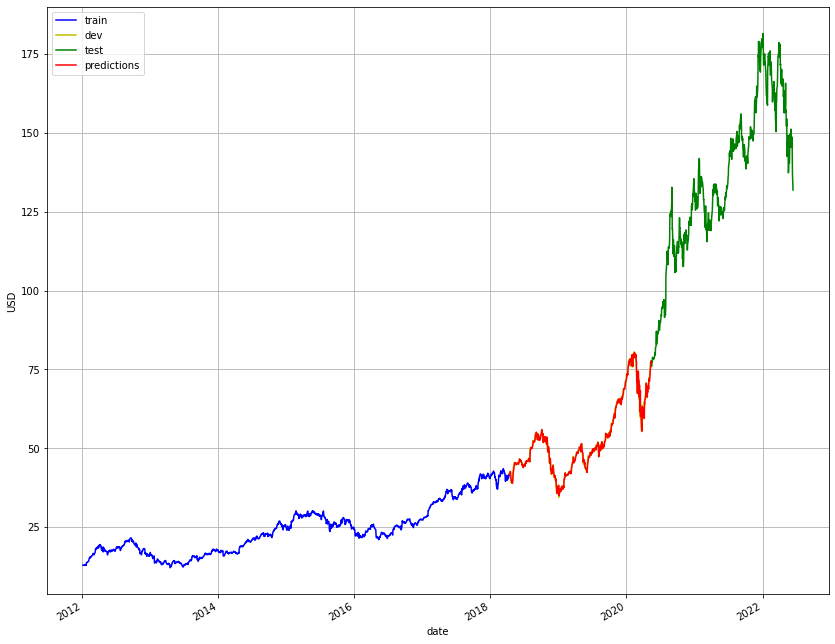

In [100]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 14, 12 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

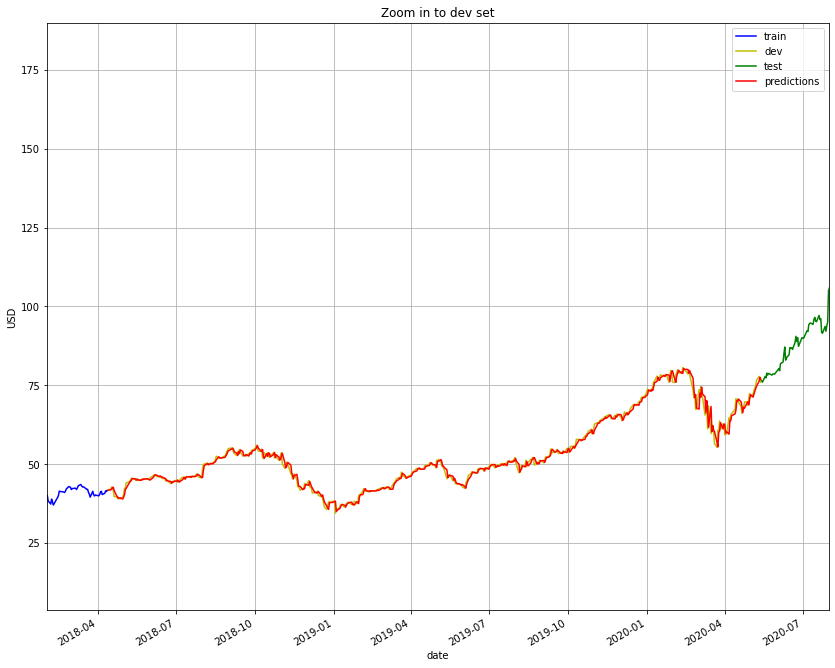

In [101]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 2, 1), date(2020, 7, 31)])
ax.set_title("Zoom in to dev set")

In [102]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_oc_lag_3', 0.00022205323),
 ('volume_lag_3', 0.00022419557),
 ('volume_lag_2', 0.00023718496),
 ('range_hl_lag_3', 0.0002544929),
 ('range_oc_lag_1', 0.00027125806),
 ('range_oc_lag_2', 0.00028368153),
 ('volume_lag_1', 0.00031360568),
 ('adj_close_lag_3', 0.015533837),
 ('adj_close_lag_2', 0.27768117),
 ('adj_close_lag_1', 0.70466673)]

## Model Tuning

#### Tuning Number of days as a feature

We got N=3 for the lowest RMSE and MAPE

In [103]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
d_df = pd.DataFrame(d)
d_df.sort_values(by='rmse_dev_set', ascending=True)

,N,rmse_dev_set,mape_pct_dev_set
1,3,1.214,0.581
0,2,1.225,0.585
2,4,1.231,0.590
3,5,1.249,0.601
5,7,1.251,0.612
4,6,1.254,0.609
6,14,1.498,0.763


In [104]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate  


Minutes taken = 0.4697757562001546


,n_estimators,max_depth,rmse,mape_pct
0,10,2,1.273820,1.535019
1,10,3,1.269314,1.516207
2,10,4,1.266450,1.508493
3,10,5,1.269196,1.513262
4,10,6,1.266750,1.503233
...,...,...,...,...
235,300,5,1.265559,1.488836
236,300,6,1.263372,1.477077
237,300,7,1.272792,1.474532
238,300,8,1.274395,1.474459


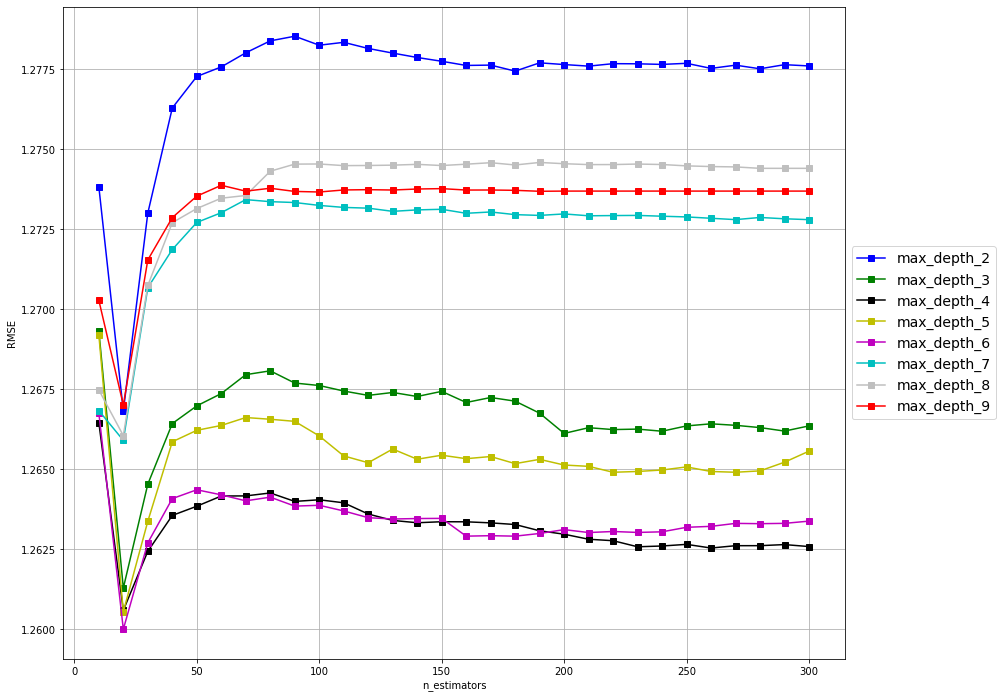

In [105]:
import matplotlib
# Plot performance versus params
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [106]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 1.260
optimum params = 


(20, 6)

In [107]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.473%
optimum params = 


(40, 8)

In [108]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.03474913438161214


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,1.462360,1.791280
1,0.001,6,1.462370,1.791252
2,0.001,7,1.462370,1.791252
3,0.001,8,1.462370,1.791252
4,0.001,9,1.462370,1.791252
...,...,...,...,...
107,0.300,16,1.272281,1.476845
108,0.300,17,1.270574,1.483860
109,0.300,18,1.273911,1.480999
110,0.300,19,1.271773,1.477837


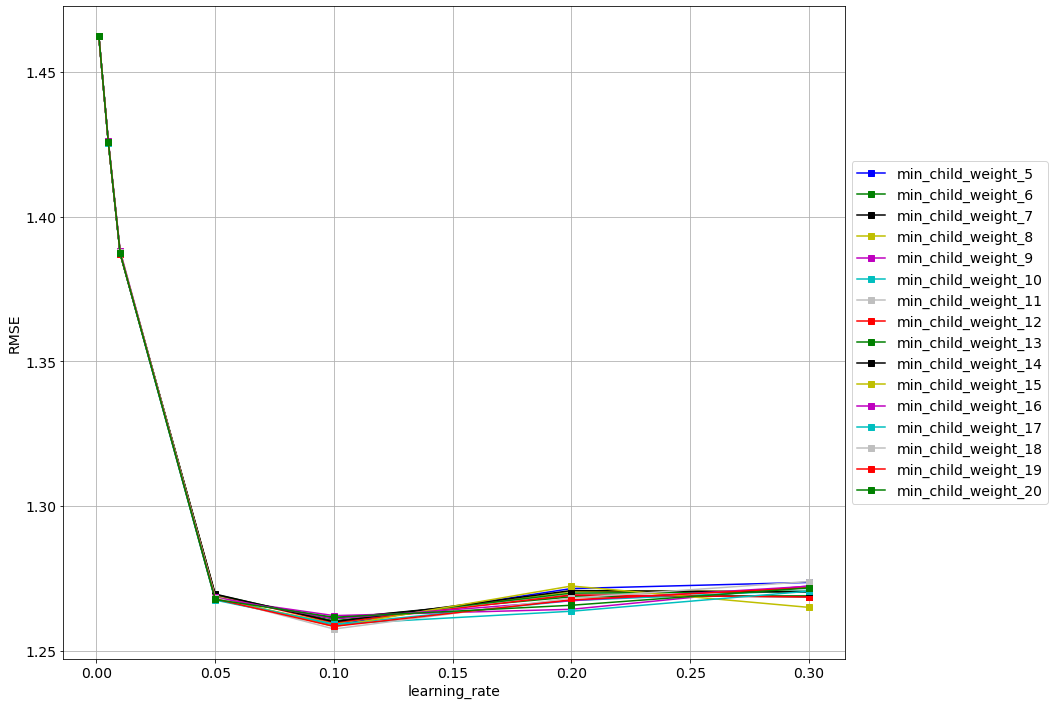

In [109]:
# Plot performance versus params
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [110]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.258
optimum params = 


(0.1, 18)

In [111]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.475%
optimum params = 


(0.3, 15)

In [112]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.02890622615814209


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,1.251261,1.484497
1,0.1,0.2,1.251519,1.485122
2,0.1,0.3,1.262517,1.496554
3,0.1,0.4,1.258315,1.484249
4,0.1,0.5,1.261164,1.501179
...,...,...,...,...
95,1.0,0.6,1.260691,1.478030
96,1.0,0.7,1.261088,1.474279
97,1.0,0.8,1.259832,1.471260
98,1.0,0.9,1.258494,1.470865


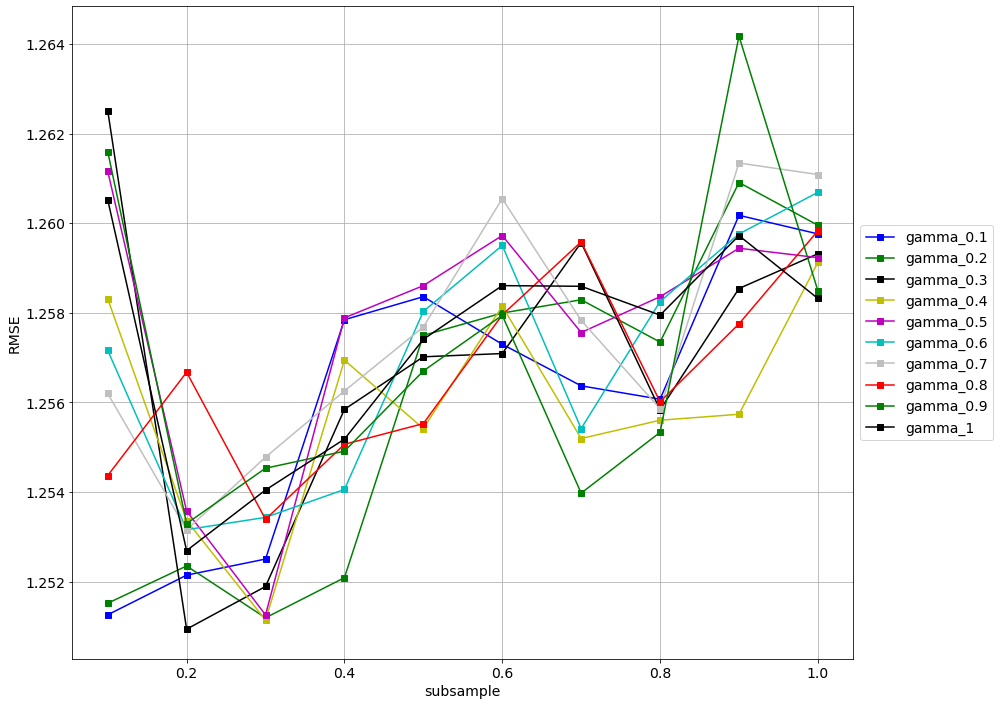

In [113]:
# Plot performance versus params
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [114]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.251
optimum params = 


(0.2, 0.3)

In [115]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.467%
optimum params = 


(0.7, 0.9)

In [116]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.008236388365427652


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,1.420819,1.805931
1,0.5,0.6,1.420819,1.805931
2,0.5,0.7,1.409675,1.811883
3,0.5,0.8,1.409675,1.811883
4,0.5,0.9,1.399454,1.796277
5,0.5,1.0,1.397945,1.804892
6,0.6,0.5,1.407024,1.833922
7,0.6,0.6,1.395294,1.814307
8,0.6,0.7,1.395294,1.814307
9,0.6,0.8,1.410683,1.824303


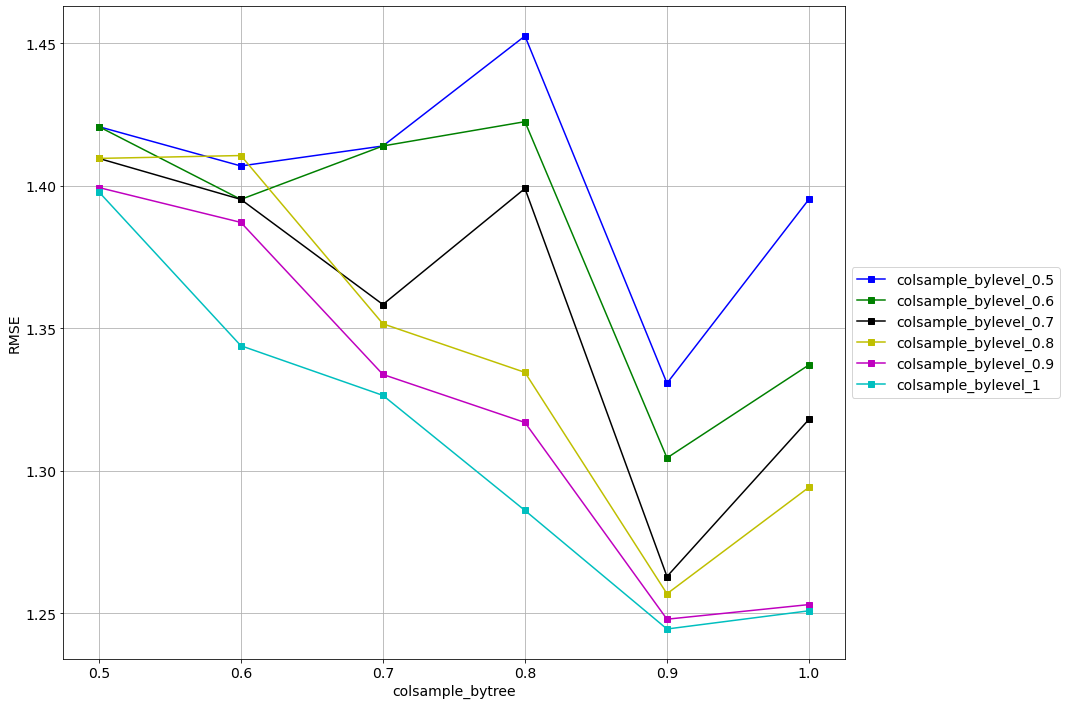

In [117]:
# Plot performance versus params
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [118]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.245
optimum params = 


(0.9, 1.0)

In [119]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.473%
optimum params = 


(1.0, 1.0)

#### Tuned Hyperparameters

In [120]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,20.000
1,max_depth,3.000,6.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,18.000
4,subsample,1.000,0.200
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.300
8,rmse,1.268,1.245
9,mape_pct,1.478,1.473


#### Final Model

In [121]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2.839
MAPE on test set = 1.574%


Text(0, 0.5, 'USD')

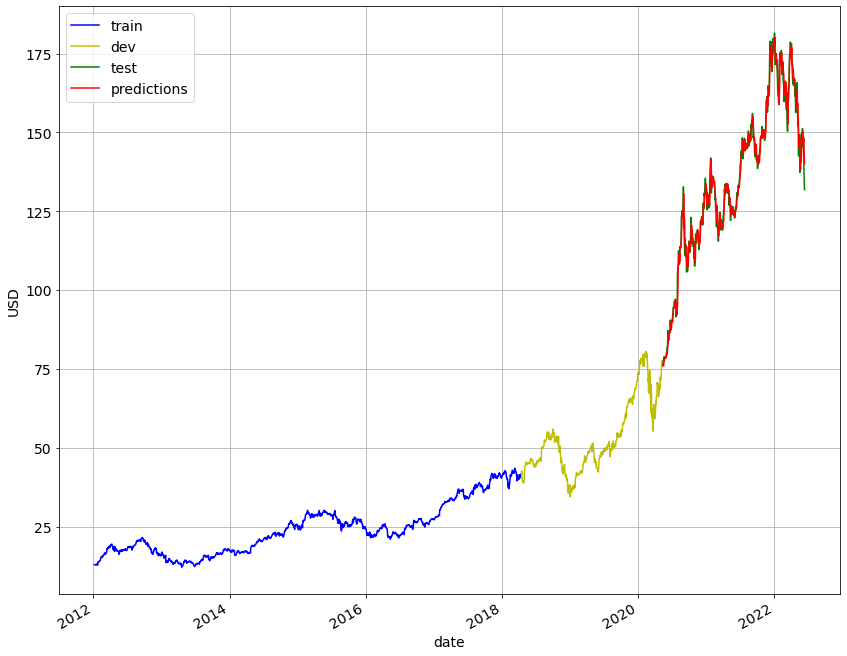

In [122]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 14, 12 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

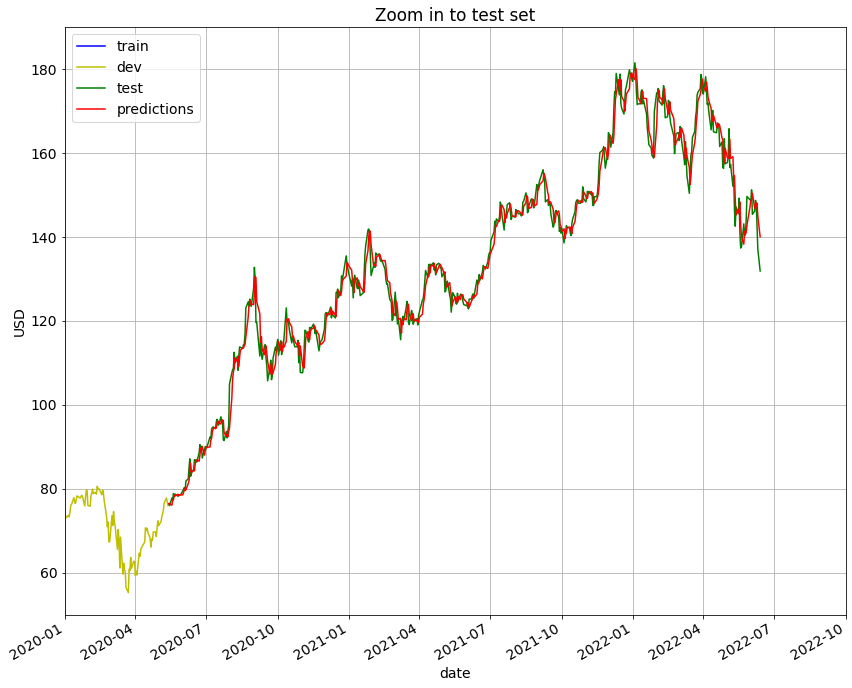

In [123]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 1, 1), date(2022, 10, 1)])
ax.set_ylim([50, 190])
ax.set_title("Zoom in to test set")

(70.0, 190.0)

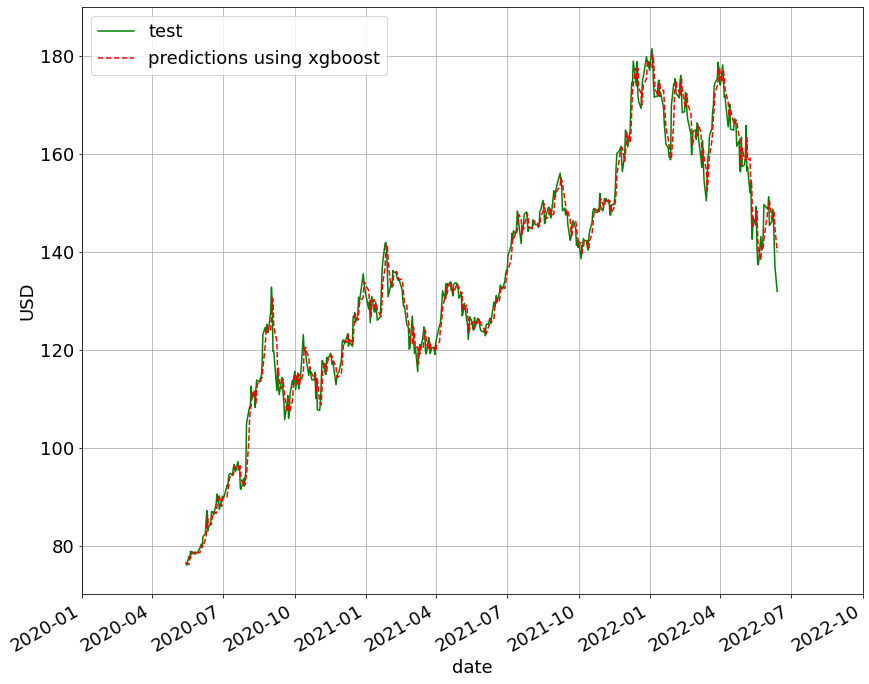

In [124]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 14, 12 # width 10, height 8
matplotlib.rcParams.update({'font.size': 18})

ax = test.plot(x='date', y='adj_close', linestyle='-', color='g', grid=True)
ax = est_df.plot(x='date', y='est', linestyle='--',color='r', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 1, 1), date(2022, 10, 1)])
ax.set_ylim([70, 190])

### Model Portfolio Generation 

This is a generation of model portfolios based on investor's preference on risk and reward.

In [125]:
log_ret = np.log(price_data/price_data.shift(1))

In [126]:
cov_mat = log_ret.cov() * 252
print(cov_mat)

Symbols      AAPL      MSFT      AMZN     GOOGL      TSLA
Symbols                                                  
AAPL     0.082365  0.043305  0.041534  0.039620  0.056186
MSFT     0.043305  0.067318  0.044636  0.043116  0.052809
AMZN     0.041534  0.044636  0.098372  0.047603  0.060847
GOOGL    0.039620  0.043116  0.047603  0.066139  0.050002
TSLA     0.056186  0.052809  0.060847  0.050002  0.316273


In [127]:
# Simulating 5000 portfolios
num_port = 5000
# Creating an empty array to store portfolio weights
all_wts = np.zeros((num_port, len(price_data.columns)))
# Creating an empty array to store portfolio returns
port_returns = np.zeros((num_port))
# Creating an empty array to store portfolio risks
port_risk = np.zeros((num_port))
# Creating an empty array to store portfolio sharpe ratio
sharpe_ratio = np.zeros((num_port))

In [128]:
for i in range(num_port):
  wts = np.random.uniform(size = len(price_data.columns))
  wts = wts/np.sum(wts)
  
  # saving weights in the array
  
  all_wts[i,:] = wts
  
  # Portfolio Returns
  
  port_ret = np.sum(log_ret.mean() * wts)
  port_ret = (port_ret + 1) ** 252 - 1
  
  # Saving Portfolio returns
  
  port_returns[i] = port_ret
  
  
  # Portfolio Risk
  
  port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
  
  port_risk[i] = port_sd
  
  # Portfolio Sharpe Ratio
  # Assuming 0% Risk Free Rate
  
  sr = port_ret / port_sd
  sharpe_ratio[i] = sr

In [129]:
names = price_data.columns
min_var = all_wts[port_risk.argmin()]
print(min_var)

[0.20711304 0.35615399 0.1183384  0.31764181 0.00075277]


In [130]:
max_sr = all_wts[sharpe_ratio.argmax()]
print(max_sr)

[0.23930655 0.34582872 0.18145431 0.00347478 0.22993564]


In [131]:
print(sharpe_ratio.max())

1.3066639267237292


In [132]:
print(port_risk.min())

0.22569390146700186


We are showing the weight assignments for different equities. 

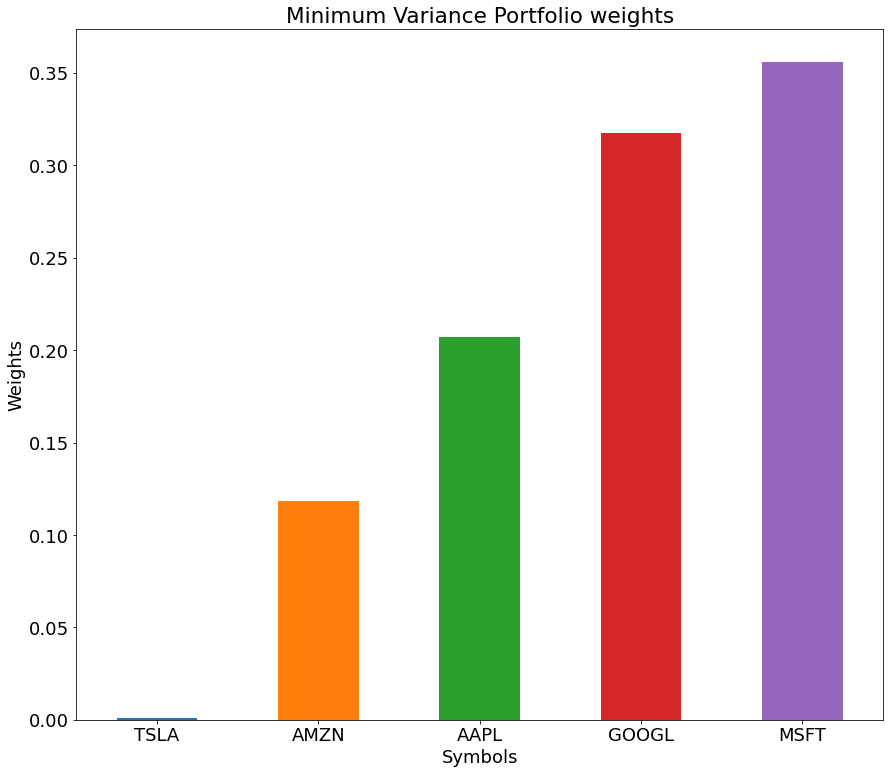

In [133]:
min_var = pd.Series(min_var, index=names)
min_var = min_var.sort_values()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Assets')
ax1.set_ylabel("Weights")
ax1.set_title("Minimum Variance Portfolio weights")
min_var.plot(kind = 'bar', color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
plt.xticks(rotation=0)
plt.show();


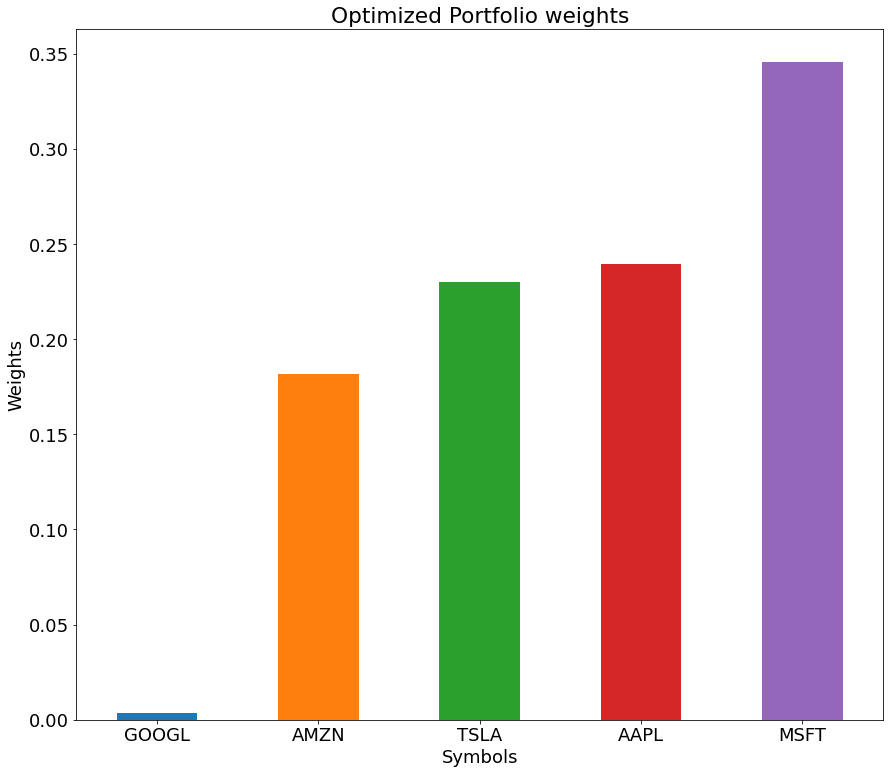

In [134]:
max_sr = pd.Series(max_sr, index=names)
max_sr = max_sr.sort_values()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Optimized Portfolio weights")
max_sr.plot(kind = 'bar', color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
plt.xticks(rotation=0)
plt.show();

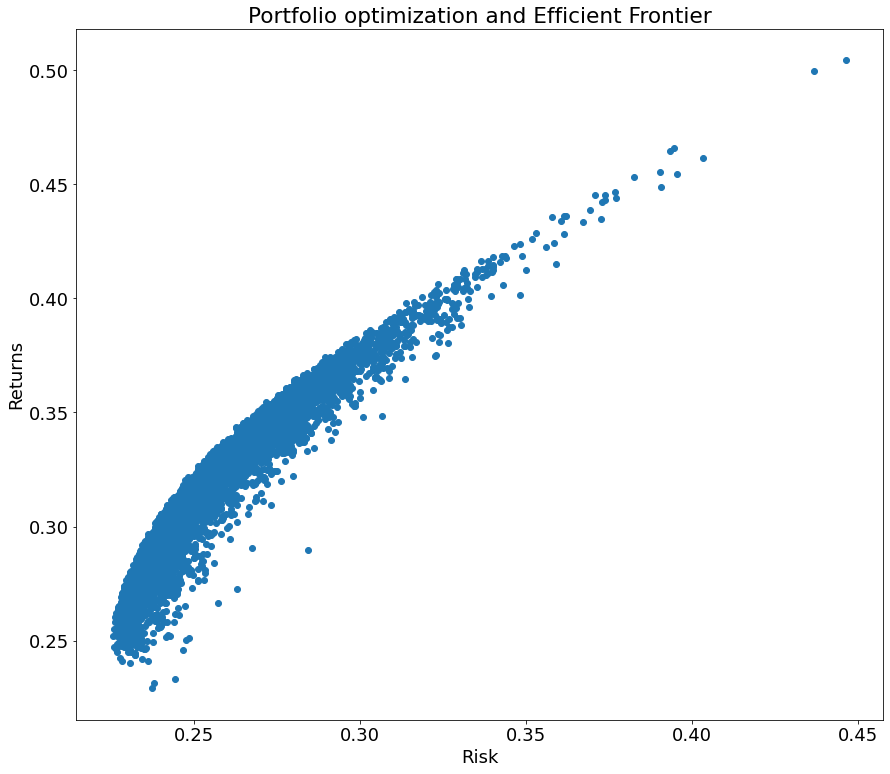

In [135]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Risk')
ax1.set_ylabel("Returns")
ax1.set_title("Portfolio optimization and Efficient Frontier")
plt.scatter(port_risk, port_returns)
plt.show();

#### Fama-French Factors modeling (Just exploring the exposure to different factors in time series)

Use Fama-Frech model to find the factors that most related to the market return

In [136]:
# This is just an example for period of 1980 to 2022. I will dig deeper into sub-periods for more details
ff_factors = pd.read_csv('data/F-F_Research_Data_Factors.csv', skiprows = 3, nrows = 1151, index_col = 0)
ff_factors

,Mkt-RF,SMB,HML,RF
192607,2.96,-2.38,-2.73,0.22
192608,2.64,-1.47,4.14,0.25
192609,0.36,-1.39,0.12,0.23
192610,-3.24,-0.13,0.65,0.32
192611,2.53,-0.16,-0.38,0.31
...,...,...,...,...
202201,-6.25,-5.93,12.74,0.00
202202,-2.29,2.18,3.09,0.00
202203,3.06,-1.61,-1.82,0.00
202204,-9.45,-1.40,6.16,0.00


In [137]:
ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-01,2.96,-2.38,-2.73,0.22
1926-08-01,2.64,-1.47,4.14,0.25
1926-09-01,0.36,-1.39,0.12,0.23
1926-10-01,-3.24,-0.13,0.65,0.32
1926-11-01,2.53,-0.16,-0.38,0.31
...,...,...,...,...
2022-01-01,-6.25,-5.93,12.74,0.00
2022-02-01,-2.29,2.18,3.09,0.00
2022-03-01,3.06,-1.61,-1.82,0.00
2022-04-01,-9.45,-1.40,6.16,0.00


In [138]:
ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-31,2.96,-2.38,-2.73,0.22
1926-08-31,2.64,-1.47,4.14,0.25
1926-09-30,0.36,-1.39,0.12,0.23
1926-10-31,-3.24,-0.13,0.65,0.32
1926-11-30,2.53,-0.16,-0.38,0.31
...,...,...,...,...
2022-01-31,-6.25,-5.93,12.74,0.00
2022-02-28,-2.29,2.18,3.09,0.00
2022-03-31,3.06,-1.61,-1.82,0.00
2022-04-30,-9.45,-1.40,6.16,0.00


In [139]:
ff_factors = ff_factors.apply(lambda x: x/ 100)
ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-31,0.0296,-0.0238,-0.0273,0.0022
1926-08-31,0.0264,-0.0147,0.0414,0.0025
1926-09-30,0.0036,-0.0139,0.0012,0.0023
1926-10-31,-0.0324,-0.0013,0.0065,0.0032
1926-11-30,0.0253,-0.0016,-0.0038,0.0031
...,...,...,...,...
2022-01-31,-0.0625,-0.0593,0.1274,0.0000
2022-02-28,-0.0229,0.0218,0.0309,0.0000
2022-03-31,0.0306,-0.0161,-0.0182,0.0000
2022-04-30,-0.0945,-0.0140,0.0616,0.0000


In [140]:
# Last day of FF data
ff_last = ff_factors.index[ff_factors.shape[0] - 1].date()
# Build the get_price function
# We need 3 arguments, ticker, start and end date
def get_price_data(ticker, start, end):
    price = web.get_data_yahoo(ticker, start, end)
    price = price['Adj Close'] # keep only the Adj Price col
    return price

In [141]:
# Get Price data for Fidelity's fund
price_data = get_price_data("FCNTX", "1980-01-01", "2022-06-01")
# Make sure to only have data upto last date of Fama French data
price_data = price_data.loc[:ff_last]
price_data

Date
1980-01-02     0.134105
1980-01-03     0.132336
1980-01-04     0.134341
1980-01-07     0.133869
1980-01-08     0.137643
                ...    
2022-05-24    13.870000
2022-05-25    14.000000
2022-05-26    14.300000
2022-05-27    14.650000
2022-05-31    14.580000
Name: Adj Close, Length: 10695, dtype: float64

In [142]:
def get_return_data(price_data, period = "M"):
    
    # Resample the data to monthly price
    price = price_data.resample(period).last()
    
    # Calculate the percent change
    ret_data = price.pct_change()[1:]
    
    # convert from series to DataFrame
    ret_data = pd.DataFrame(ret_data)
    
    # Rename the Column
    ret_data.columns = ['portfolio']
    return ret_data
    
ret_data = get_return_data(price_data, "M")
ret_data.tail()

,portfolio
Date,
2022-01-31,-0.082090
2022-02-28,-0.048706
2022-03-31,0.032777
2022-04-30,-0.115569
2022-05-31,-0.012864


In [143]:
# Merging the data
all_data = pd.merge(pd.DataFrame(ret_data),ff_factors, how = 'inner', left_index= True, right_index= True)
# Rename the columns
all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)
# Calculate the excess returns
all_data['port_excess'] = all_data['portfolio'] - all_data['RF']
all_data

,portfolio,mkt_excess,SMB,HML,RF,port_excess
1980-02-29,-0.016874,-0.0122,-0.0185,0.0061,0.0089,-0.025774
1980-03-31,-0.089431,-0.1290,-0.0664,-0.0101,0.0121,-0.101531
1980-04-30,0.017857,0.0397,0.0105,0.0108,0.0126,0.005257
1980-05-31,0.078947,0.0526,0.0213,0.0038,0.0081,0.070847
1980-06-30,0.011743,0.0306,0.0166,-0.0076,0.0061,0.005643
...,...,...,...,...,...,...
2022-01-31,-0.082090,-0.0625,-0.0593,0.1274,0.0000,-0.082090
2022-02-28,-0.048706,-0.0229,0.0218,0.0309,0.0000,-0.048706
2022-03-31,0.032777,0.0306,-0.0161,-0.0182,0.0000,0.032777
2022-04-30,-0.115569,-0.0945,-0.0140,0.0616,0.0000,-0.115569


In [144]:
model = sm.formula.ols(formula = "port_excess ~ mkt_excess + SMB + HML", data = all_data).fit()
model.params

Intercept     0.001204
mkt_excess    0.900894
SMB           0.011596
HML          -0.132520
dtype: float64

### Model Portfolio Return Compared to Market Index

In [145]:
df = web.get_data_yahoo('SPY', '2017-01-01', '2022-06-01')
df = df.dropna()
df = df.iloc[:,:4]
df

,High,Low,Open,Close
Date,,,,
2017-01-03,225.830002,223.880005,225.039993,225.240005
2017-01-04,226.750000,225.610001,225.619995,226.580002
2017-01-05,226.580002,225.479996,226.270004,226.399994
2017-01-06,227.750000,225.899994,226.529999,227.210007
2017-01-09,227.070007,226.419998,226.910004,226.460007
...,...,...,...,...
2022-05-25,399.450012,391.890015,392.309998,397.369995
2022-05-26,407.040009,398.450012,398.670013,405.309998
2022-05-27,415.380005,407.700012,407.910004,415.260010


In [146]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
# df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

In [147]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [148]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

In [149]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,High,[-0.008007575987315597]
1,Low,[0.013501758218867932]
2,Open,[0.018612409465622315]
3,Close,[-0.014495049775411337]
4,S_10,[-0.008479133652102353]
5,Corr,[-0.14026662201733725]
6,Open-Close,[-0.06046327305723207]
7,Open-Open,[-0.030081032126287453]


In [150]:
probability = model.predict_proba(X_test)
probability

array([[0.40913354, 0.59086646],
       [0.3110622 , 0.6889378 ],
       [0.38325915, 0.61674085],
       [0.3093478 , 0.6906522 ],
       [0.4469964 , 0.5530036 ],
       [0.44627472, 0.55372528],
       [0.52122252, 0.47877748],
       [0.5305097 , 0.4694903 ],
       [0.55038101, 0.44961899],
       [0.52349246, 0.47650754],
       [0.36648387, 0.63351613],
       [0.62947905, 0.37052095],
       [0.28548414, 0.71451586],
       [0.43521433, 0.56478567],
       [0.37088402, 0.62911598],
       [0.44235895, 0.55764105],
       [0.49202013, 0.50797987],
       [0.36976725, 0.63023275],
       [0.41246585, 0.58753415],
       [0.38177307, 0.61822693],
       [0.41104621, 0.58895379],
       [0.4379779 , 0.5620221 ],
       [0.47668171, 0.52331829],
       [0.41407781, 0.58592219],
       [0.41051114, 0.58948886],
       [0.37736795, 0.62263205],
       [0.47749632, 0.52250368],
       [0.39727956, 0.60272044],
       [0.42346669, 0.57653331],
       [0.43437519, 0.56562481],
       [0.

In [151]:
predicted = model.predict(X_test)
predicted

array([ 1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [152]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 16 170]
 [  8 210]]


In [153]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.67      0.09      0.15       186
           1       0.55      0.96      0.70       218

    accuracy                           0.56       404
   macro avg       0.61      0.52      0.43       404
weighted avg       0.61      0.56      0.45       404



In [154]:
print(model.score(X_test,y_test))


0.5594059405940595


In [155]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.55555556 0.56296296 0.55555556 0.56296296 0.57037037 0.58208955
 0.59701493 0.56716418 0.55223881 0.49253731]
0.5598452183526811


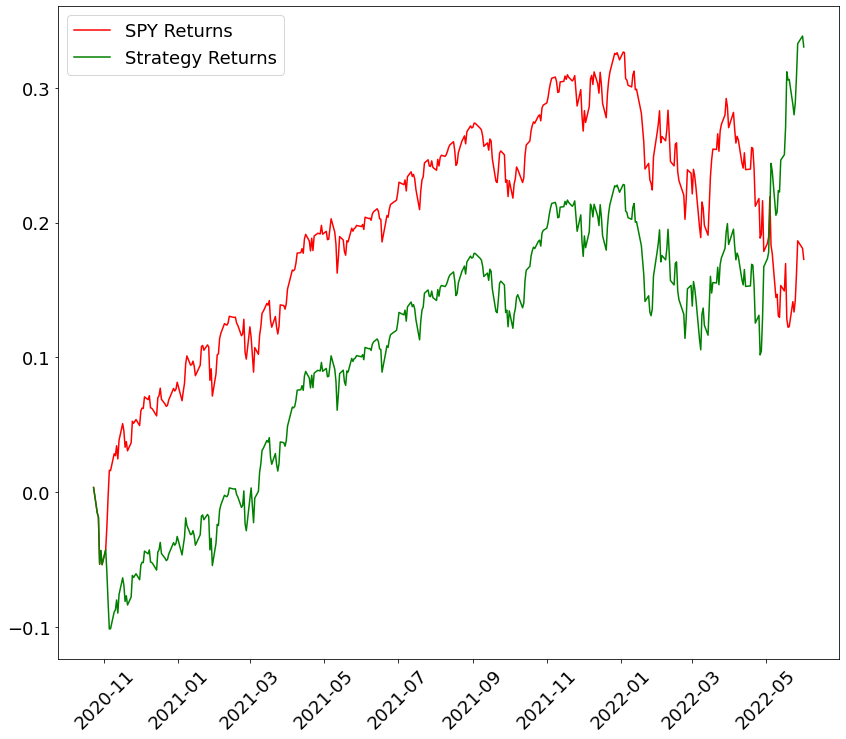

In [156]:
df['Predicted_Signal'] = model.predict(X)
df['SPY_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_spy_returns = np.cumsum(df[split:]['SPY_returns'])

df['Strategy_returns'] = df['SPY_returns'] * df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Strategy_returns'])
alpha = Cumulative_Strategy_returns - Cumulative_spy_returns

plt.figure(figsize=(14,12))
plt.plot(Cumulative_spy_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [157]:
alpha.mean()

-0.08723380536363655

### Minimum Variance Model Portfolio 

In [158]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]
prices = web.get_data_yahoo(tickers,
start = "2017-01-01",
end = "2022-06-01")
prices

Attributes   Adj Close                                                   \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA   
Date                                                                      
2017-01-03   27.257643   57.930538   37.683498   808.010010   43.397999   
2017-01-04   27.227140   57.671329   37.859001   807.770020   45.397999   
2017-01-05   27.365593   57.671329   39.022499   813.020020   45.349998   
2017-01-06   27.670675   58.171211   39.799500   825.210022   45.801998   
2017-01-09   27.924126   57.986061   39.846001   827.179993   46.256001   
...                ...         ...         ...          ...         ...   
2022-05-25  140.520004  262.519989  106.775002  2116.100098  658.799988   
2022-05-26  143.779999  265.899994  111.077499  2155.850098  707.729980   
2022-05-27  149.639999  273.239990  115.146500  2246.330078  759.630005   
2022-05-31  148.839996  271.869995  120.209503  2275.239990  758.260010   
2022-06-01  148.710007  272.420013  121.683998  2277.840088  740.369995   

Attributes       Close                                                   \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA   
Date                                                                      
2017-01-03   29.037500   62.580002   37.683498   808.010010   43.397999   
2017-01-04   29.004999   62.299999   37.859001   807.770020   45.397999   
2017-01-05   29.152500   62.299999   39.022499   813.020020   45.349998   
2017-01-06   29.477501   62.840000   39.799500   825.210022   45.801998   
2017-01-09   29.747499   62.639999   39.846001   827.179993   46.256001   
...                ...         ...         ...          ...         ...   
2022-05-25  140.520004  262.519989  106.775002  2116.100098  658.799988   
2022-05-26  143.779999  265.899994  111.077499  2155.850098  707.729980   
2022-05-27  149.639999  273.239990  115.146500  2246.330078  759.630005   
2022-05-31  148.839996  271.869995  120.209503  2275.239990  758.260010   
2022-06-01  148.710007  272.420013  121.683998  2277.840088  740.369995   

Attributes        High                                                   \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA   
Date                                                                      
2017-01-03   29.082500   62.840000   37.938000   811.440002   44.066002   
2017-01-04   29.127501   62.750000   37.984001   813.429993   45.599998   
2017-01-05   29.215000   62.660000   39.119999   813.739990   45.495998   
2017-01-06   29.540001   63.150002   39.972000   828.960022   46.062000   
2017-01-09   29.857500   63.080002   40.088501   830.429993   46.383999   
...                ...         ...         ...          ...         ...   
2022-05-25  141.789993  264.579987  108.175003  2130.000000  669.320007   
2022-05-26  144.339996  267.109985  112.665497  2172.989990  718.669983   
2022-05-27  149.679993  273.339996  115.186996  2246.360107  759.799988   
2022-05-31  150.660004  274.769989  121.994499  2314.699951  778.799988   
2022-06-01  151.740005  277.690002  125.179001  2342.030029  771.979980   

Attributes         Low                                                   \
Symbols           AAPL        MSFT        AMZN        GOOGL        TSLA   
Date                                                                      
2017-01-03   28.690001   62.130001   37.384998   796.890015   42.192001   
2017-01-04   28.937500   62.119999   37.709999   804.109985   42.862000   
2017-01-05   28.952499   62.029999   38.013000   805.919983   44.389999   
2017-01-06   29.117500   62.040001   38.924000   811.500000   45.090000   
2017-01-09   29.485001   62.540001   39.588501   821.619995   45.599998   
...                ...         ...         ...          ...         ...   
2022-05-25  138.339996  257.130005  103.650002  2077.129883  623.010010   
2022-05-26  137.139999  261.429993  107.453499  2104.500000  653.659973   
2022-05-27  145.259995

In [159]:
price_data = prices['Adj Close']
price_data

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Date,,,,,
2017-01-03,27.257643,57.930538,37.683498,808.010010,43.397999
2017-01-04,27.227140,57.671329,37.859001,807.770020,45.397999
2017-01-05,27.365593,57.671329,39.022499,813.020020,45.349998
2017-01-06,27.670675,58.171211,39.799500,825.210022,45.801998
2017-01-09,27.924126,57.986061,39.846001,827.179993,46.256001
...,...,...,...,...,...
2022-05-25,140.520004,262.519989,106.775002,2116.100098,658.799988
2022-05-26,143.779999,265.899994,111.077499,2155.850098,707.729980
2022-05-27,149.639999,273.239990,115.146500,2246.330078,759.630005


In [160]:
ret_data = price_data.pct_change()[1:]
ret_data.head()

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Date,,,,,
2017-01-04,-0.001119,-0.004474,0.004657,-0.000297,0.046085
2017-01-05,0.005085,0.000000,0.030732,0.006499,-0.001057
2017-01-06,0.011148,0.008668,0.019912,0.014993,0.009967
2017-01-09,0.009160,-0.003183,0.001168,0.002387,0.009912
2017-01-10,0.001008,-0.000319,-0.001280,-0.001414,-0.006097


In [162]:
min_var

Symbols
TSLA     0.000753
AMZN     0.118338
AAPL     0.207113
GOOGL    0.317642
MSFT     0.356154
dtype: float64

In [163]:
w = [0.22, 0.34, 0.11, 0.32, 0.01]

In [164]:
weighted_returns = (w * ret_data)
weighted_returns.head()

Symbols,AAPL,MSFT,AMZN,GOOGL,TSLA
Date,,,,,
2017-01-04,-0.000246,-0.001521,0.000512,-0.000095,0.000461
2017-01-05,0.001119,0.000000,0.003381,0.002080,-0.000011
2017-01-06,0.002453,0.002947,0.002190,0.004798,0.000100
2017-01-09,0.002015,-0.001082,0.000129,0.000764,0.000099
2017-01-10,0.000222,-0.000109,-0.000141,-0.000453,-0.000061


In [165]:
port_ret = weighted_returns.sum(axis=1)
port_ret

Date
2017-01-04   -0.000889
2017-01-05    0.006569
2017-01-06    0.012488
2017-01-09    0.001924
2017-01-10   -0.000541
                ...   
2022-05-25    0.006865
2022-05-26    0.020668
2022-05-27    0.036545
2022-05-31    0.006056
2022-06-01    0.001975
Length: 1362, dtype: float64

In [166]:
cumulative_ret = (port_ret + 1).cumprod()

In [167]:
df

,High,Low,Open,Close,S_10,Corr,Open-Close,Open-Open,Predicted_Signal,SPY_returns,Strategy_returns
Date,,,,,,,,,,,
2017-01-30,228.199997,226.410004,228.169998,227.550003,227.482002,0.706241,-0.800003,-1.250000,1,NaN,NaN
2017-01-31,227.600006,226.320007,226.979996,227.529999,227.610002,0.556063,-0.570007,-1.190002,1,-0.000088,-0.000088
2017-02-01,228.589996,226.940002,227.529999,227.619995,227.697002,0.454110,0.000000,0.550003,1,0.000395,0.000395
2017-02-02,228.100006,226.820007,227.619995,227.770004,227.883002,0.276854,0.000000,0.089996,1,0.000659,0.000659
2017-02-03,229.550003,228.460007,228.820007,229.339996,228.143001,0.318922,1.050003,1.200012,1,0.006869,0.006869
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,399.450012,391.890015,392.309998,397.369995,396.160001,0.446024,-1.580017,-0.250000,1,0.008796,0.008796
2022-05-26,407.040009,398.450012,398.670013,405.309998,397.457001,0.505855,1.300018,6.360016,1,0.019784,0.019784
2022-05-27,415.380005,407.700012,407.910004,415.260010,398.811002,0.329182,2.600006,9.239990,-1,0.024253,0.024253


In [168]:
df_close = df['Close']
df_close

Date
2017-01-30    227.550003
2017-01-31    227.529999
2017-02-01    227.619995
2017-02-02    227.770004
2017-02-03    229.339996
                 ...    
2022-05-25    397.369995
2022-05-26    405.309998
2022-05-27    415.260010
2022-05-31    412.929993
2022-06-01    409.589996
Name: Close, Length: 1345, dtype: float64

In [169]:
spy_monthly_returns = df_close.pct_change()
spy_monthly_returns

Date
2017-01-30         NaN
2017-01-31   -0.000088
2017-02-01    0.000396
2017-02-02    0.000659
2017-02-03    0.006893
                ...   
2022-05-25    0.008835
2022-05-26    0.019981
2022-05-27    0.024549
2022-05-31   -0.005611
2022-06-01   -0.008089
Name: Close, Length: 1345, dtype: float64

In [170]:
spy_cum_returns = (spy_monthly_returns + 1).cumprod()
spy_cum_returns

Date
2017-01-30         NaN
2017-01-31    0.999912
2017-02-01    1.000308
2017-02-02    1.000967
2017-02-03    1.007866
                ...   
2022-05-25    1.746297
2022-05-26    1.781191
2022-05-27    1.824918
2022-05-31    1.814678
2022-06-01    1.800000
Name: Close, Length: 1345, dtype: float64

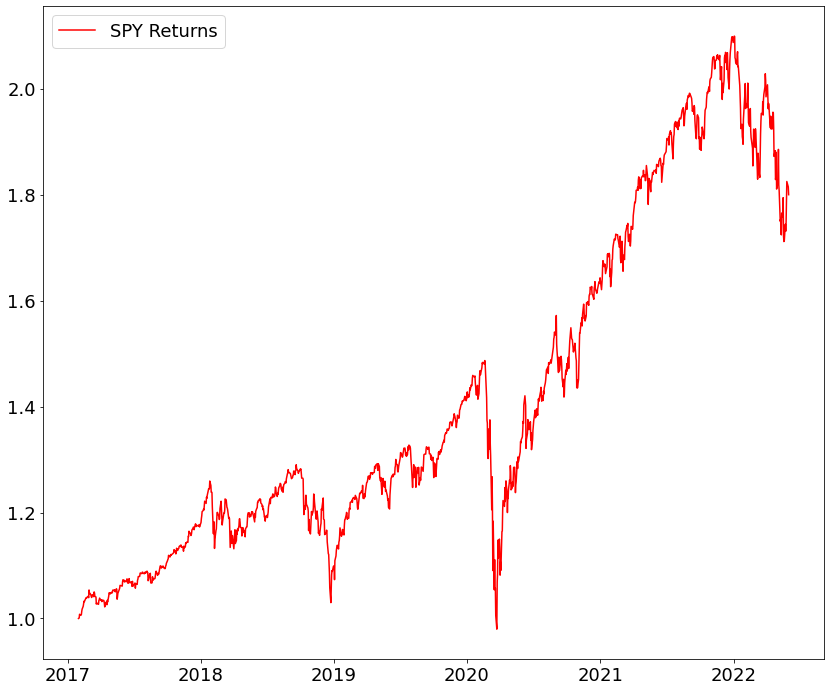

In [171]:
plt.figure(figsize=(14,12))
plt.plot(spy_cum_returns, color='r',label = 'SPY Returns')
# plt.plot(cumulative_ret, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

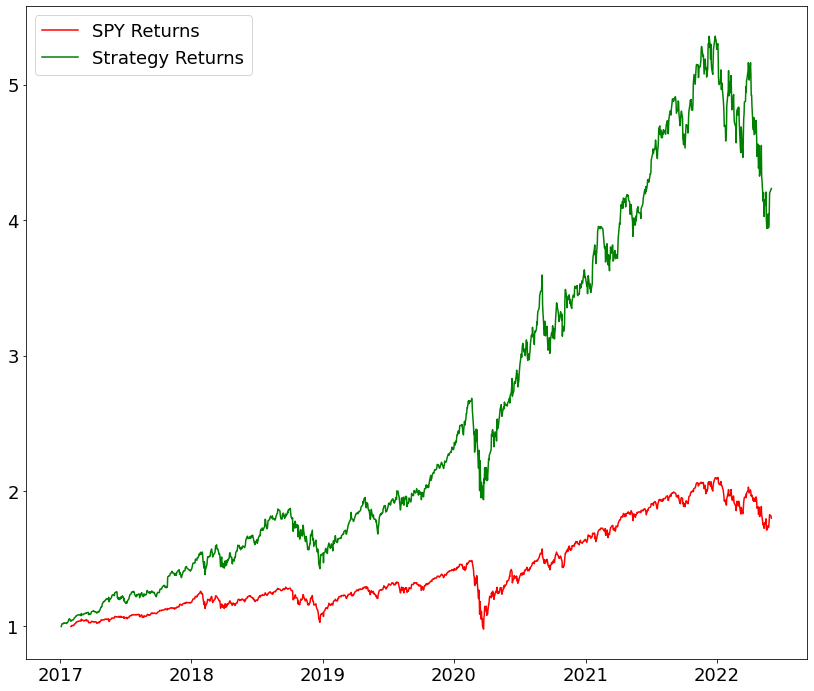

In [172]:
plt.figure(figsize=(14,12))
plt.plot(spy_cum_returns, color='r',label = 'SPY Returns')
plt.plot(cumulative_ret, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [173]:
alpha = cumulative_ret - spy_cum_returns
alpha.mean()

1.1874808171499045

## Conclusions

- There are some limitations with the product. If I could access to key datasets such as historical rating, then I could incorporate a recommendation system, which is very important for this type of product.

- XGBoost is a great algorithm but it is sensitive to outliers and not perform well on unstructured data. 

- At the end of day, price prediction is very complicated. This product is just a simplified example of how quantitative analyst would approach to financial market. At least for now, no one can predict the market movement, but the key takeaway is how you would leverage these tools to make better decision.

## Next Steps

- We would definitely need to include a recommendation system for Better Millennium. 

- LSTM (Long short-term memory) networks might be a better algorithm to take on prediction task. 